# Datascience Project: Heartbeat Notebook 1: Data Viz

## 1) Data analysis:

#

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy.stats import pearsonr, spearmanr, kruskal
import plotly.graph_objs as go
from scipy.stats import shapiro
import scipy.stats as stats
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import os

### 2.1) Downloading the data

The data can be found in Kaggle. The directory paths need to be adjusted accordingly

In [2]:
## Test cell for simon: Using Kaggle API to download the datasets indepent of github and its filesize limitations. Storing it in folder located outside of the repo.
# If this works, all filepaths have to be adjusted in all notebooks to make use of the downloaded datasets.
#RUN THIS CELL ONLY ONCE FOR ALL NOTEBOOKS!

from kaggle.api.kaggle_api_extended import KaggleApi

#configuring and authentification with kaggle api. This could be configured so that a authentification mask is shown?
api = KaggleApi()
api.authenticate()

#Configuring the metadata for the ecg heartbeat data (original username etc)
dataset_owner = "shayanfazeli"
dataset_name = "heartbeat"

#Configuring a download path that is NOT in the current github repo (so the big files are not pushed and cause an error!) --> Links to filepaths have to be dynamically adjusted
download_path = "../data/KAGGLE_datasets" #In this case we use the data folder that is in the .gitignore list and therefore not pushed! To keep everything in one local repo.

# Download structure: First check if dataset is already downloaded, else download it and store it in download path (should be outside git repo!)
dataset_folder = os.path.join(download_path, dataset_name)
if not os.path.exists(dataset_folder):
    # Case 1: Dataset path is not created --> Create it and download datasets into it
    api.dataset_download_files(dataset_owner + "/" + dataset_name, path=download_path + "/" + dataset_name, unzip=True)
    print("Datasets are downloaded and unzipped.")
else:
    # Case 2: Folder is created, but datasets might be missing
    missing_files = [] 
    for file_name in ["mitbih_test.csv", "mitbih_train.csv", "ptbdb_abnormal.csv", "ptbdb_normal.csv"]:  # These are the hardcoded names of the datasets that should be downloaded.
        file_path = os.path.join(dataset_folder, file_name)
        if not os.path.exists(file_path):
            missing_files.append(file_name)

    if missing_files:
        # If the list contains missing files, download ALL files and overwrite the old folder.
        api.dataset_download_files(dataset_owner + "/" + dataset_name, path=download_path + "/" + dataset_name, unzip=True, force=True)
        print("Missing data was donwloaded and unzipped. All Datasets are now available.")
    else:
        print("All Datasets are already available.")

#Creating new variable that links to the datasets and can be used in the rest of the code.
path_to_datasets = download_path + "/" + dataset_name 

All Datasets are already available.


In [3]:

#reading in the datasets from the local ../data folder --> this folder is not pushed on github and only locally available.
mitbih_test = pd.read_csv(path_to_datasets + "/" + "mitbih_test.csv",header=None)
mitbih_train = pd.read_csv(path_to_datasets + "/" + "mitbih_train.csv",header=None)
ptbdb_abnormal = pd.read_csv(path_to_datasets + "/" + "ptbdb_abnormal.csv",header=None)
ptbdb_normal = pd.read_csv(path_to_datasets + "/" + "ptbdb_normal.csv",header=None)
print("All Datasets are read in correctly")


All Datasets are read in correctly


### 2.1.1) Describing and characterizing the data

#### 2.1.1.1) Check Columns

In [4]:
#Check the Dataframes for similiarities in the columns
def check_dataframes(*dataframes, tolerance=0.1):
    """
    Check if the provided DataFrames have the same number of columns,
    same column names in the same order, and similar values in the columns.
    
    Parameters:
        dataframes: Variable number of pandas DataFrames to be checked.
        tolerance (float): Tolerance level for checking similarity of values.
                           Default is 0.1 (10% tolerance).
    
    Returns:
        bool: True if all checks pass, False otherwise.
    """
      
    checker = True
    # Check if the number of columns is the same for all DataFrames
    num_columns = len(dataframes[0].columns)
    if not all(len(df.columns) == num_columns for df in dataframes):
        print("Number of columns is not the same for all DataFrames.")
        checker = False
    else:
        print("Number of columns is the same for all DataFrames")
        checker = True
    
    # Check if column names are the same in the same order
    reference_columns = dataframes[0].columns.tolist()
    if not all(df.columns.tolist() == reference_columns for df in dataframes):
        print("Column names are not the same for all DataFrames or not in the same order.")
        checker = False
    
    """# Check if values in columns have similar statistics (mean and std)
    reference_stats = dataframes[0].describe()
    for df in dataframes[1:]:
        stats_diff = (df.describe() - reference_stats) / reference_stats
        print(stats_diff)
        print("-----")
        for stat_name in stats_diff.columns:
            if not np.all(np.abs(stats_diff[stat_name]) <= tolerance):
                print(f"{stat_name}: Fail")
                checker = False
            else:
                print(f"{stat_name}: Pass")"""
    
    #All checks passed
    print(f"All checks passed: {checker}")
    return checker

print("Check for mitbih dataframes (tolerance 25%)")
check_dataframes(mitbih_test, mitbih_train, tolerance=0.25)
print("------------------------------------------------------")

print("Check for ptbd dataframes (tolerance 25%)")
check_dataframes(ptbdb_abnormal, ptbdb_normal, tolerance=0.25)
print("------------------------------------------------------")

print("Check for all four dataframes (tolerance 25%)")
check_dataframes(mitbih_test, mitbih_train, ptbdb_abnormal, ptbdb_normal, tolerance=0.25)
print("------------------------------------------------------")


Check for mitbih dataframes (tolerance 25%)
Number of columns is the same for all DataFrames
All checks passed: True
------------------------------------------------------
Check for ptbd dataframes (tolerance 25%)
Number of columns is the same for all DataFrames
All checks passed: True
------------------------------------------------------
Check for all four dataframes (tolerance 25%)
Number of columns is the same for all DataFrames
All checks passed: True
------------------------------------------------------


#### 2.1.1.2) Info, heads and missing values for each df

In [5]:
#Display Info, heads and null / NaN-values for each df, also sum of dtypes
print("Evaluation of mitbhih_test")
display(mitbih_test.info())
display(mitbih_test.head())
print("Number of 0-values in mitbih_test: ", (mitbih_test.isnull().sum().sum()))
print("Number of NaN-values in mitbih_test: ", (mitbih_test.isna().sum().sum()))
dtypes=[]
for col in mitbih_test.columns:
    dtype = mitbih_test[col].dtype
    dtypes.append(dtype)
print("unique values of dtypes:")
display(pd.crosstab(dtypes, "counts", rownames=["Data type"], colnames=["Amount in columns"]))

print("---------------------------------------------------------------------------------------------------------------------------------")
print("Evaluation of mitbhih_train")
display(mitbih_train.info())
display(mitbih_train.head())
print("Number of 0-values in mitbih_train: ", (mitbih_train.isnull().sum().sum()))
print("Number of NaN-values in mitbih_train: ", (mitbih_train.isna().sum().sum()))
dtypes=[]
for col in mitbih_train.columns:
    dtype = mitbih_train[col].dtype
    dtypes.append(dtype)
print("unique values of dtypes:")
display(pd.crosstab(dtypes, "counts", rownames=["Data type"], colnames=["Amount in columns"]))


print("---------------------------------------------------------------------------------------------------------------------------------")
print("Evaluation of ptbd_abnormal")
display(ptbdb_abnormal.info())
display(ptbdb_abnormal.head())
print("Number of 0-values in ptbdb_abnormal: ", (ptbdb_abnormal.isnull().sum().sum()))
print("Number of NaN-values in ptbdb_abnormal: ", (ptbdb_abnormal.isna().sum().sum()))
dtypes=[]
for col in ptbdb_abnormal.columns:
    dtype = ptbdb_abnormal[col].dtype
    dtypes.append(dtype)
print("unique values of dtypes:")
display(pd.crosstab(dtypes, "counts", rownames=["Data type"], colnames=["Amount in columns"]))

print("---------------------------------------------------------------------------------------------------------------------------------")
print("Evaluation of ptbd_normal")
display(ptbdb_normal.info())
display(ptbdb_normal.head())
print("Number of 0-values in ptbdb_normal: ", (ptbdb_normal.isnull().sum().sum()))
print("Number of NaN-values in ptbdb_normal: ", (ptbdb_normal.isna().sum().sum()))
dtypes=[]
for col in ptbdb_normal.columns:
    dtype = ptbdb_normal[col].dtype
    dtypes.append(dtype)
print("unique values of dtypes:")
display(pd.crosstab(dtypes, "counts", rownames=["Data type"], colnames=["Amount in columns"]))

Evaluation of mitbhih_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


None

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of 0-values in mitbih_test:  0
Number of NaN-values in mitbih_test:  0
unique values of dtypes:


Amount in columns,counts
Data type,
float64,188


---------------------------------------------------------------------------------------------------------------------------------
Evaluation of mitbhih_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


None

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of 0-values in mitbih_train:  0
Number of NaN-values in mitbih_train:  0
unique values of dtypes:


Amount in columns,counts
Data type,
float64,188


---------------------------------------------------------------------------------------------------------------------------------
Evaluation of ptbd_abnormal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 15.1 MB


None

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Number of 0-values in ptbdb_abnormal:  0
Number of NaN-values in ptbdb_abnormal:  0
unique values of dtypes:


Amount in columns,counts
Data type,
float64,188


---------------------------------------------------------------------------------------------------------------------------------
Evaluation of ptbd_normal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 5.8 MB


None

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of 0-values in ptbdb_normal:  0
Number of NaN-values in ptbdb_normal:  0
unique values of dtypes:


Amount in columns,counts
Data type,
float64,188


In [6]:
# Create a dictionary to store the evaluation metrics --> Done manually only for report usage.
evaluation_results = {
    "Dataset": ["mitbih_test", "mitbih_train", "ptbdb_abnormal", "ptbdb_normal"],
    "RangeIndex": [21891, 87553, 10505, 4045],
    "Memory Usage (MB)": [31.4, 125.6, 15.1, 5.8],
    "Number of 0-values": [0, 0, 0, 0],
    "Number of NaN-values": [0, 0, 0, 0],
    "Data Types": ["float64 (188)", "float64 (188)", "float64 (188)", "float64 (188)"]
}

# Create a DataFrame from the dictionary
evaluation_df = pd.DataFrame(evaluation_results)

# Display the DataFrame
display(evaluation_df)

,Dataset,RangeIndex,Memory Usage (MB),Number of 0-values,Number of NaN-values,Data Types
0,mitbih_test,21891,31.4,0,0,float64 (188)
1,mitbih_train,87553,125.6,0,0,float64 (188)
2,ptbdb_abnormal,10505,15.1,0,0,float64 (188)
3,ptbdb_normal,4045,5.8,0,0,float64 (188)


#### Conclusion from 2.1.1.2) 

We have no missing values, no NaN-values and no zero values.
The data seems to be already preprocessed, so that we can start with the examination.
No further preprocessing is needed, over- or undersampling can be applied directly if needed.

#### 2.1.1.3) Describing the target variable(s)
Goal: How many target variables are there, how are they distributed and what can we conclude from it?
differentiated by Dataframe and overall Dataset

Examination of target variable in mitbih_train
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Examination of target variable in mitbih_test
187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


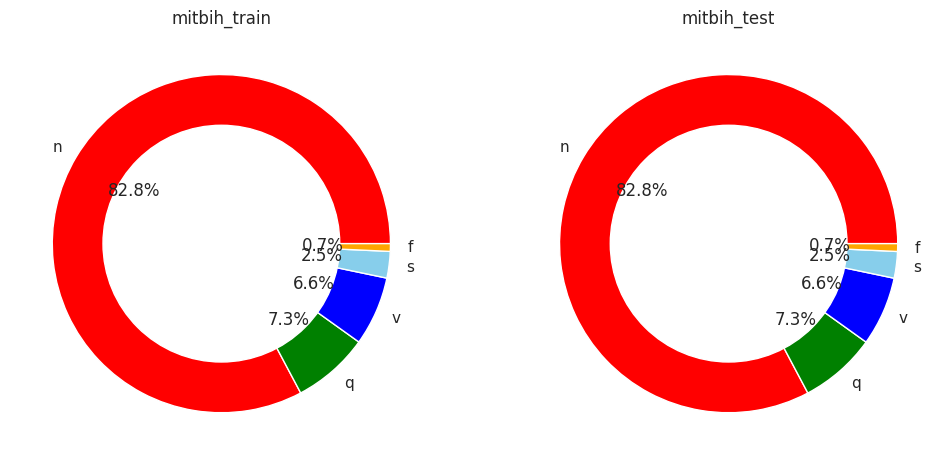

-------------------------------------------------------
Examination of target variable in ptbdb_abnormal
187
1.0    10506
Name: count, dtype: int64

Examination of target variable in ptbdb_normal
187
0.0    4046
Name: count, dtype: int64


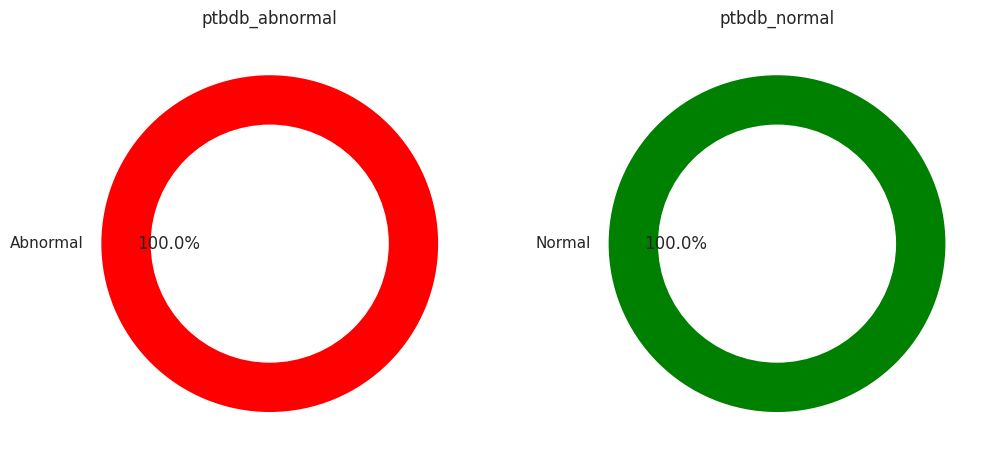

In [21]:
# Examination of target variable in mitbih_train
equilibre_train = mitbih_train.iloc[:, -1].value_counts()
print("Examination of target variable in mitbih_train")
print(equilibre_train)

# Examination of target variable in mitbih_test
equilibre_test = mitbih_test.iloc[:, -1].value_counts()
print("\nExamination of target variable in mitbih_test")
print(equilibre_test)

plt.figure(figsize=(12, 6))  # Erstellen einer gemeinsamen Figure

# Plot für mitbih_train
plt.subplot(1, 2, 1)  # Erstellen von Subplots: 1 Reihe, 2 Spalten, erster Plot
plt.title("mitbih_train")
my_circle_train = plt.Circle((0, 0), 0.7, color='white')
plt.pie(equilibre_train, labels=['n', 'q', 'v', 's', 'f'], colors=['red', 'green', 'blue', 'skyblue', 'orange'], autopct='%1.1f%%')
plt.gca().add_artist(my_circle_train)

# Plot für mitbih_test
plt.subplot(1, 2, 2)  # zweiter Plot in der gleichen Reihe
plt.title("mitbih_test")
my_circle_test = plt.Circle((0, 0), 0.7, color='white')
plt.pie(equilibre_test, labels=['n', 'q', 'v', 's', 'f'], colors=['red', 'green', 'blue', 'skyblue', 'orange'], autopct='%1.1f%%')
plt.gca().add_artist(my_circle_test)
plt.savefig("../reports/figures/viz_plots/target_distribution_mitbih", dpi=300)
plt.show()
print("-------------------------------------------------------")

# Examination of target variable in ptbdb_abnormal
equilibre_abnormal = ptbdb_abnormal.iloc[:, -1].value_counts()
print("Examination of target variable in ptbdb_abnormal")
print(equilibre_abnormal)

# Examination of target variable in ptbdb_normal
equilibre_normal = ptbdb_normal.iloc[:, -1].value_counts()
print("\nExamination of target variable in ptbdb_normal")
print(equilibre_normal)

plt.figure(figsize=(12, 6))  # Erstellen einer gemeinsamen Figure

# Plot für ptbdb_abnormal
plt.subplot(1, 2, 1)  # Erstellen von Subplots: 1 Reihe, 2 Spalten, erster Plot
plt.title("ptbdb_abnormal")
my_circle_abnormal = plt.Circle((0, 0), 0.7, color='white')
plt.pie(equilibre_abnormal, labels=['Abnormal'], colors=['red'], autopct='%1.1f%%')
plt.gca().add_artist(my_circle_abnormal)

# Plot für ptbdb_normal
plt.subplot(1, 2, 2)  # zweiter Plot in der gleichen Reihe
plt.title("ptbdb_normal")
my_circle_normal = plt.Circle((0, 0), 0.7, color='white')
plt.pie(equilibre_normal, labels=['Normal'], colors=['green'], autopct='%1.1f%%')
plt.gca().add_artist(my_circle_normal)
plt.savefig("../reports/figures/viz_plots/target_distribution_ptbdb", dpi=300)
plt.show()

### 2.3 General statistical tests
In order to interpret the p-values of later tests correctly, we have to tests for the assumptions that the p-value tests require:
Statistical assumptions
Statistical tests make some common assumptions about the data they are testing:

Independence of observations, 
Homogeneity of variance,  
Normality of data 

## 3.1) General Visualization

### 3.1.1) Test for normal Distribution
Below is a function to plot the shapiro wilk p-value result for all columns except the target column.
the target column is displayed as qq plot and the p-value of a shapiro wilk test is given too.

/tmp/ipykernel_146107/1070774421.py:18: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21892.
  stat, p_value = stats.shapiro(df[col])


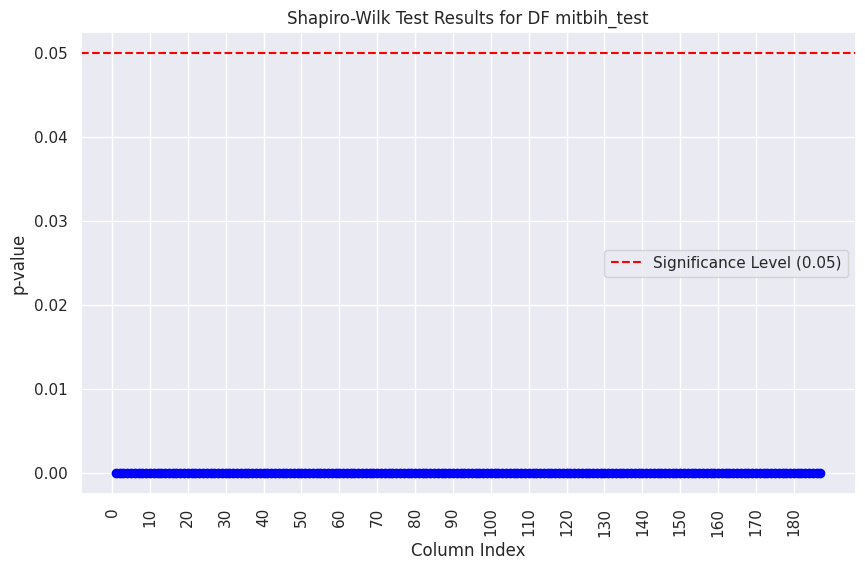

/tmp/ipykernel_146107/1070774421.py:40: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21892.
  stat, p_value = stats.shapiro(df[last_col])


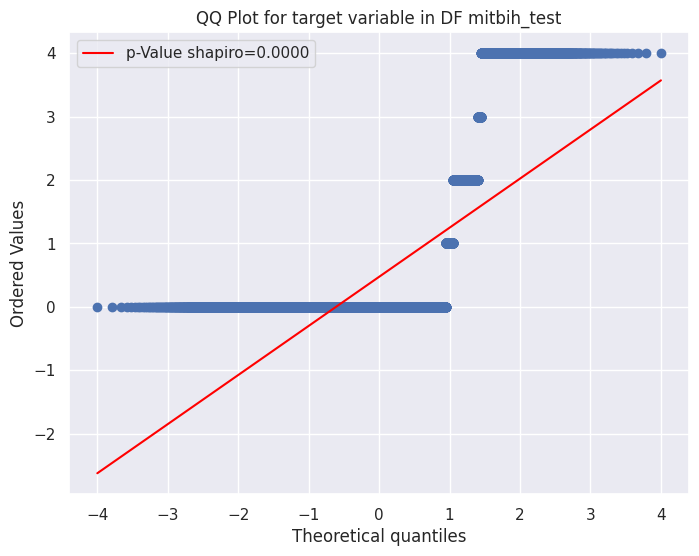

/tmp/ipykernel_146107/1070774421.py:18: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 87554.
  stat, p_value = stats.shapiro(df[col])


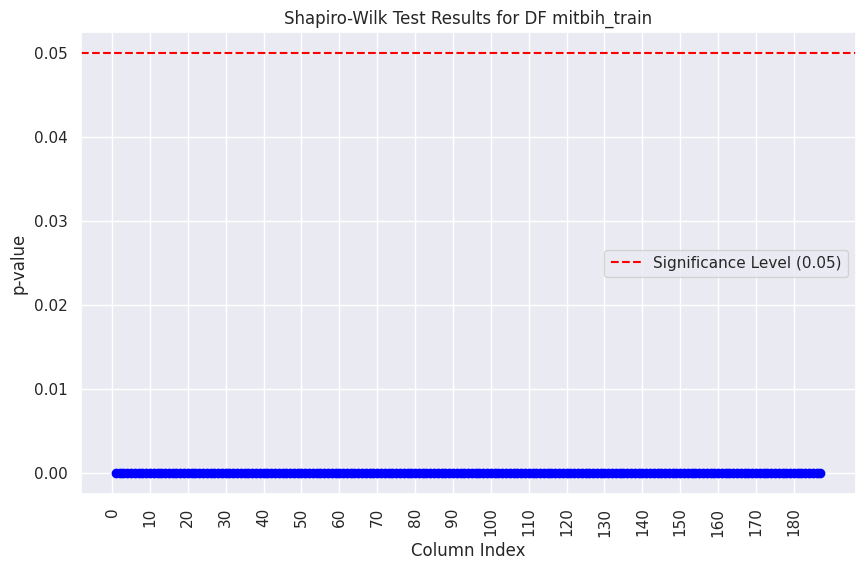

/tmp/ipykernel_146107/1070774421.py:40: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 87554.
  stat, p_value = stats.shapiro(df[last_col])


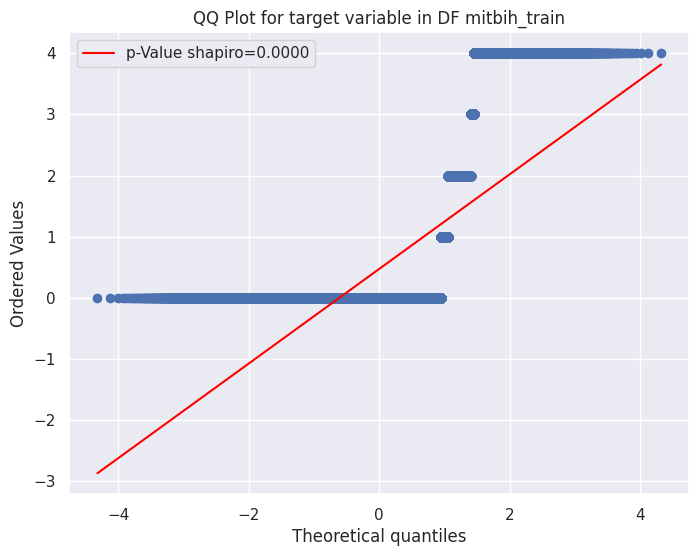

/tmp/ipykernel_146107/1070774421.py:18: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat, p_value = stats.shapiro(df[col])


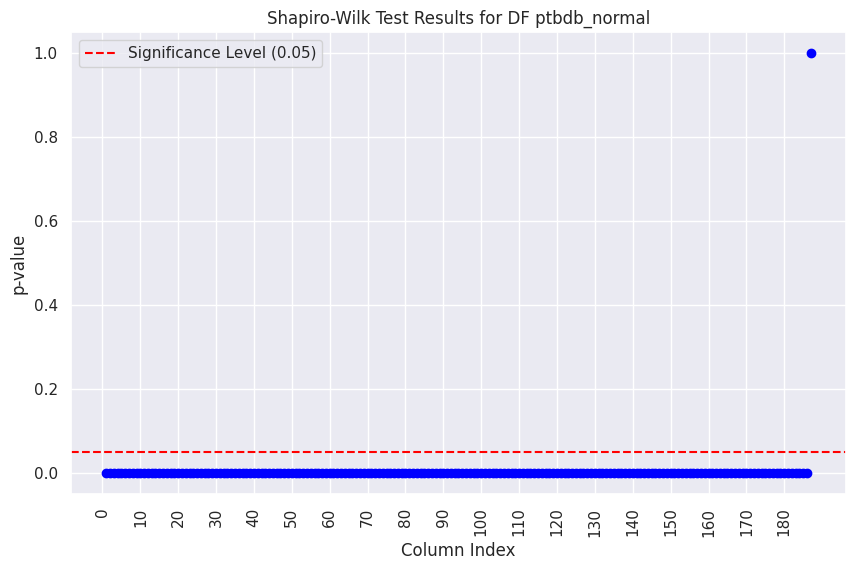

/tmp/ipykernel_146107/1070774421.py:40: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat, p_value = stats.shapiro(df[last_col])


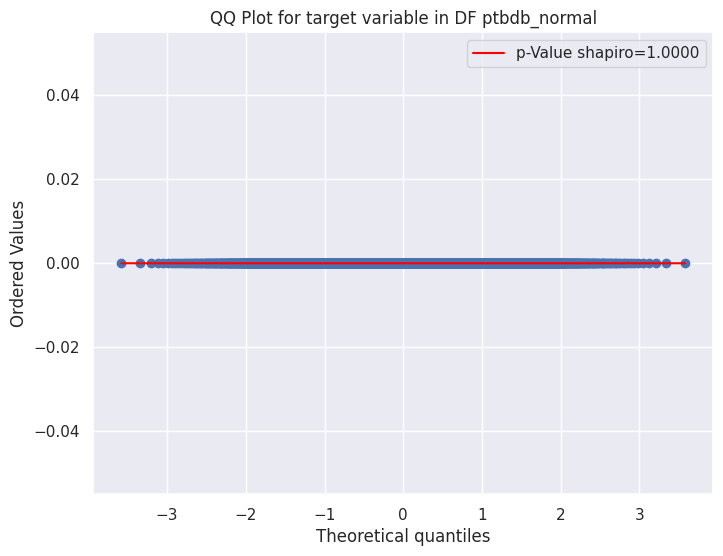

/tmp/ipykernel_146107/1070774421.py:18: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10506.
  stat, p_value = stats.shapiro(df[col])
/tmp/ipykernel_146107/1070774421.py:18: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat, p_value = stats.shapiro(df[col])


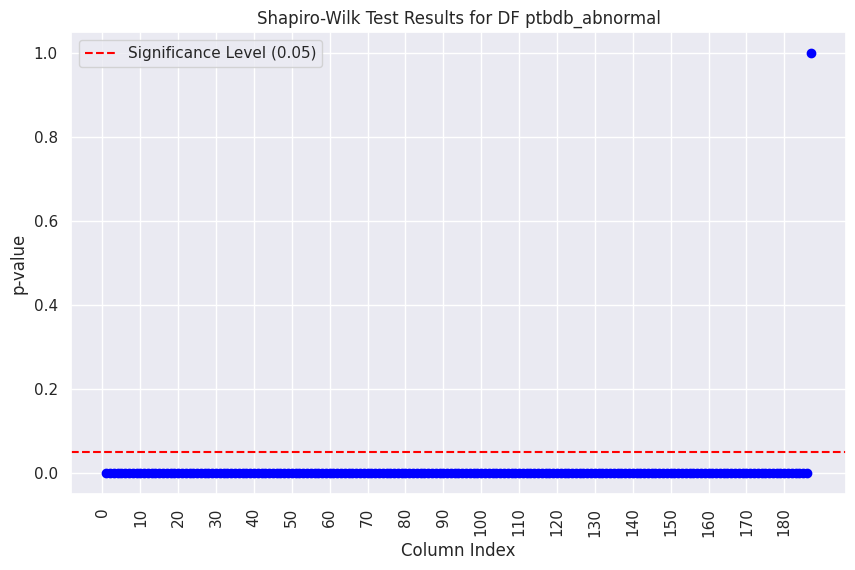

/tmp/ipykernel_146107/1070774421.py:40: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat, p_value = stats.shapiro(df[last_col])
/tmp/ipykernel_146107/1070774421.py:40: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10506.
  stat, p_value = stats.shapiro(df[last_col])


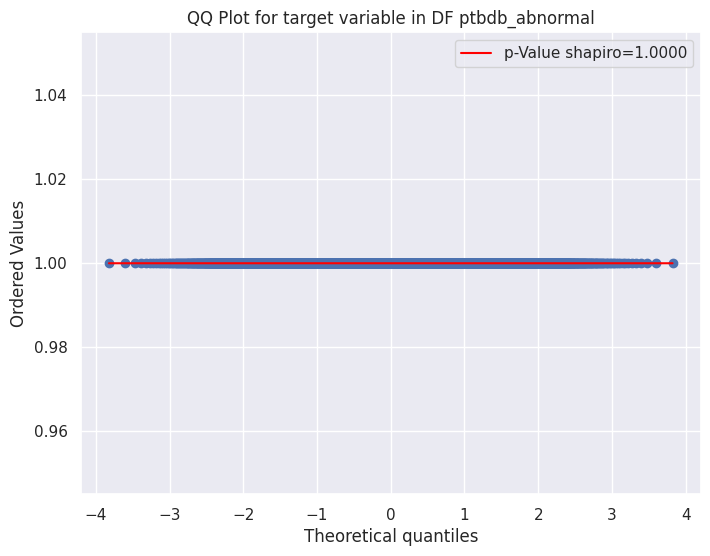

In [22]:
def shapiro_wilk_test_and_qq_plot(df):
    """
    Perform Shapiro-Wilk test for all columns of the DataFrame
    and create QQ-plot for the last column.

    Parameters:
        df (DataFrame): DataFrame containing the data for the tests.

    Returns:
        p_values (dict): Dictionary containing p-values for Shapiro-Wilk test for each column.
    """
    df_name = df.name if hasattr(df, 'name') and df.name is not None else str([name for name, obj in globals().items() if obj is df][0]);
    p_values = {}

    # Perform Shapiro-Wilk test for each column
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, col in enumerate(df.columns[:-1], 1):
        stat, p_value = stats.shapiro(df[col])
        p_values[col] = p_value
        #print(f'Shapiro-Wilk Test for {col}: Statistics={stat}, p-value={p_value}')

        # Plot the p-values
        ax.scatter(i, p_value, color='blue') #label=f'{col}'

    ax.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
    ax.set_title(f'Shapiro-Wilk Test Results for DF {df_name}')
    ax.set_xlabel('Column Index')
    ax.set_ylabel('p-value')
    ax.legend()
    xticks_positions = list(range(0, len(df.iloc[0, :-1]), 10))
    xticks_labels = [str(x) for x in xticks_positions]
    plt.xticks(xticks_positions, xticks_labels, rotation=90)
    #plt.xticks(range(1, len(df.columns[:-1]) + 1), df.columns[:-1], rotation=45) #old code
    plt.grid(True)
    plt.savefig(f"../reports/figures/viz_plots/shapiro_wilk_{df_name}", dpi=300)
    plt.show()

    # Create QQ-Plot for the last column
    last_col = df.columns[-1]
    stat, p_value = stats.shapiro(df[last_col])
    fig, ax = plt.subplots(figsize=(8, 6))
    stats.probplot(df[last_col], dist="norm", plot=ax)
    ax.get_lines()[1].set_linestyle('-')
    ax.get_lines()[1].set_color('red')
    ax.get_lines()[1].set_label('Ideal Normal Distribution')
    ax.get_lines()[1].set_label(f'p-Value shapiro={p_value:.4f}')
    ax.legend()
    ax.set_title(f'QQ Plot for target variable in DF {df_name}')
    plt.savefig(f"../reports/figures/viz_plots/QQ_Plot_target_for_{df_name}", dpi=300)
    plt.show()

    #return p_values

shapiro_wilk_test_and_qq_plot(mitbih_test)
shapiro_wilk_test_and_qq_plot(mitbih_train)

shapiro_wilk_test_and_qq_plot(ptbdb_normal)
shapiro_wilk_test_and_qq_plot(ptbdb_abnormal)

#### Evaluation for 3.1.1)
we see, that the data is completely NOT normal distributed in all datasets.
Furthermore, the target variable in ptdbd dataset is normal distributed, but only because there is only one class in each dataset.
--> We need to shuffle the data and resample it for normal distribution or work with a modle, that can use such skewed distributions.

### 3.1.2) Plot any random signal
Below is a function to plot any signal, which is further specified for our usecase (different datasets with classes)

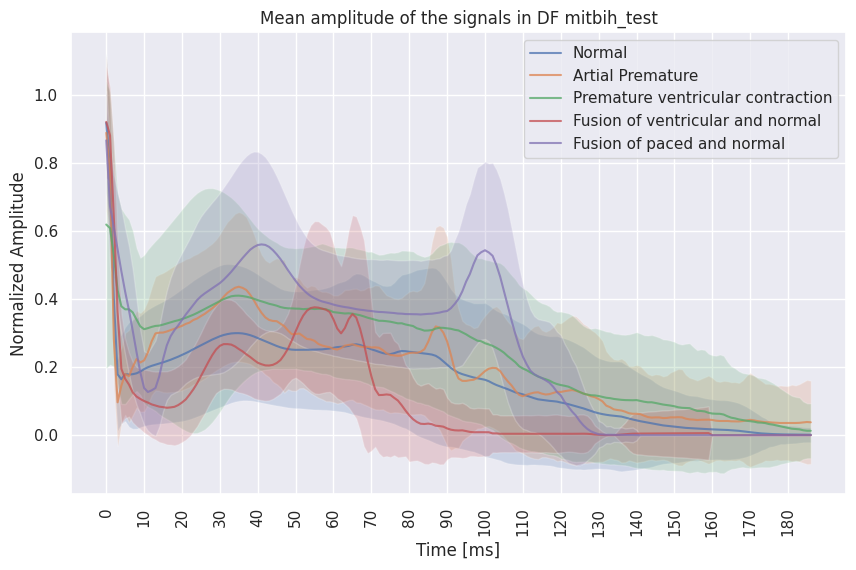

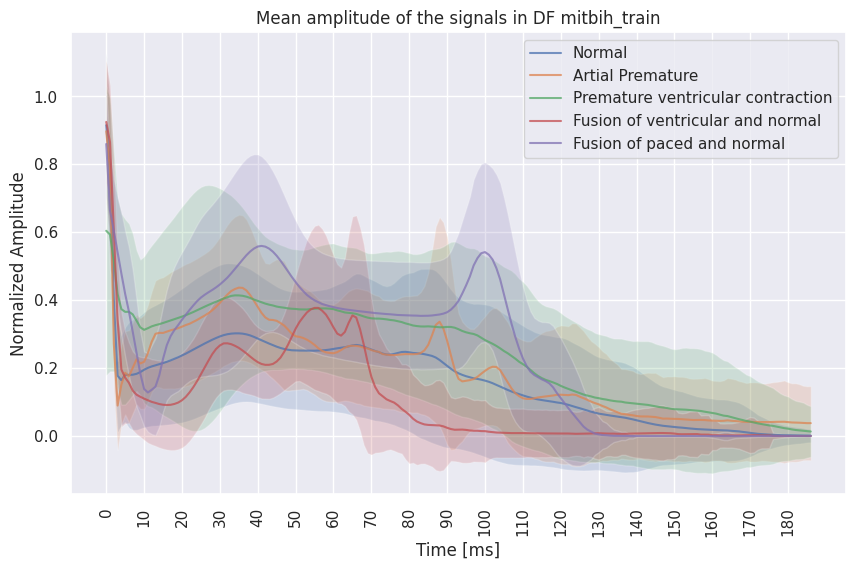

In [23]:
# plot any random signal
def plot_all_datapoints(train, ind, statistics=False):
    """
    Plot all datapoints (alpha=0.2) and mean and std for each class.

    Parameters:
        train (DataFrame): DataFrame containing the data.
        ind (int): Index of the row to plot.

    Returns:
        None
    """
    id_to_label = {
        0: "Normal",
        1: "Artial Premature",
        2: "Premature ventricular contraction",
        3: "Fusion of ventricular and normal",
        4: "Fusion of paced and normal"
    }

    # Extract label for the given index
    label1 = train.iloc[ind, 187]
    
    # Plot all datapoints with alpha=0.2
    #plt.plot(train.iloc[ind, :-1], alpha=1, label=f"Data for row {ind} \n (Class {id_to_label[label1]})")

    fig = plt.figure(figsize=(10,6))

    # Plot mean and std for each class with alpha=1
    if statistics==True:
        for i in range(5):
            class_data = train[train.iloc[:, 187] == i].iloc[:, :-1]
            mean_value = class_data.mean()
            std_value = class_data.std()
            plt.plot(mean_value, label=f"{id_to_label[i]}", alpha=0.75)
            plt.fill_between(range(len(mean_value)), mean_value - std_value, mean_value + std_value, alpha=0.2)
    
    # Add legend and show plot
    xticks_positions = list(range(0, len(train.iloc[ind, :-1]), 10))
    xticks_labels = [str(x) for x in xticks_positions]
    plt.xticks(xticks_positions, xticks_labels, rotation=90)
    plt.ylabel("Normalized Amplitude")
    plt.title(f"Mean amplitude of the signals in DF {[x for x in globals() if globals()[x] is train][0]}")
    plt.xlabel("Time [ms]")
    plt.legend()
    plt.savefig(f"../reports/figures/viz_plots/Mean_amplitude_of_signals_for_df_{[x for x in globals() if globals()[x] is train][0]}", dpi=300)
    plt.show()


#plot_all_datapoints(mitbih_test, ind=1, statistics =True)
plot_all_datapoints(mitbih_test, 500, statistics=True)

#plot_all_datapoints(mitbih_train, ind=1, statistics =True)
plot_all_datapoints(mitbih_train, 500, statistics=True)



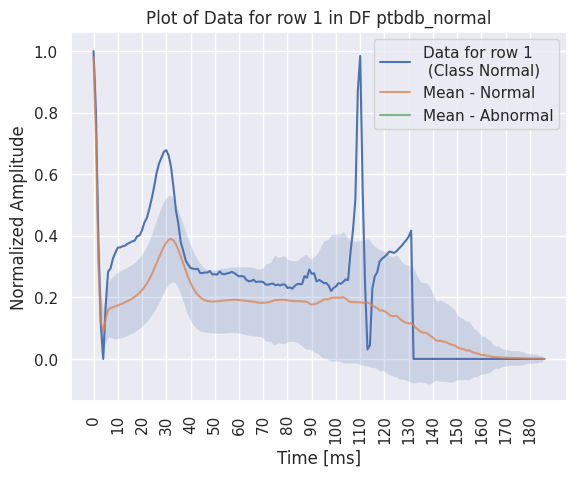

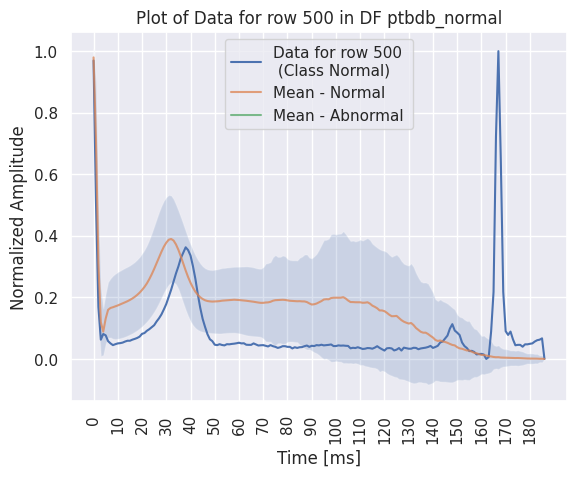

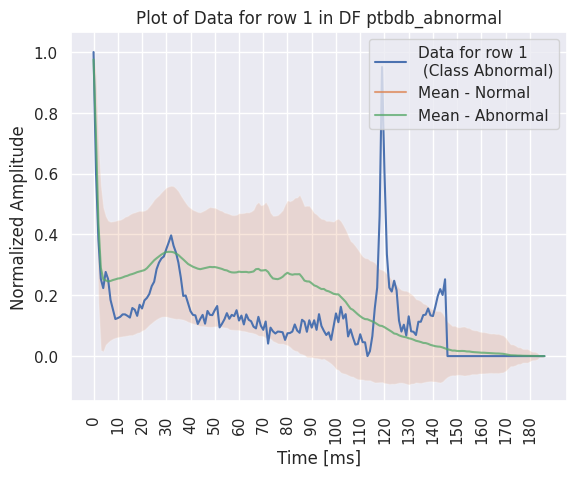

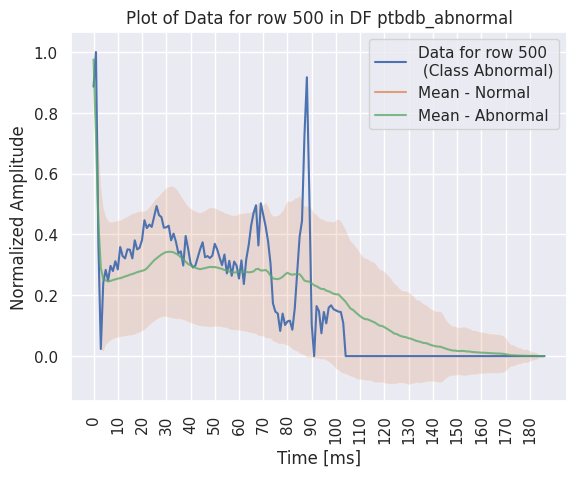

In [24]:
#The same function as before, but for ptbdb data...
def plot_all_datapoints_2(train, ind, statistics=False):
    """
    Plot all datapoints (alpha=0.2) and mean and std for each class.

    Parameters:
        train (DataFrame): DataFrame containing the data.
        ind (int): Index of the row to plot.

    Returns:
        None
    """
    id_to_label = {
        0: "Normal",
        1: "Abnormal"#,
        #2: "Premature ventricular contraction",
        #3: "Fusion of ventricular and normal",
        #4: "Fusion of paced and normal"
    }

    # Extract label for the given index
    label1 = train.iloc[ind, 187]
    
    # Plot all datapoints with alpha=0.2
    plt.plot(train.iloc[ind, :-1], alpha=1, label=f"Data for row {ind} \n (Class {id_to_label[label1]})")

    # Plot mean and std for each class with alpha=1
    if statistics==True:
        for i in range(2):
            class_data = train[train.iloc[:, 187] == i].iloc[:, :-1]
            mean_value = class_data.mean()
            std_value = class_data.std()
            plt.plot(mean_value, label=f"Mean - {id_to_label[i]}", alpha=0.75)
            plt.fill_between(range(len(mean_value)), mean_value - std_value, mean_value + std_value, alpha=0.2)
    
    # Add legend and show plot
    xticks_positions = list(range(0, len(train.iloc[ind, :-1]), 10))
    xticks_labels = [str(x) for x in xticks_positions]
    plt.xticks(xticks_positions, xticks_labels, rotation=90)
    plt.ylabel("Normalized Amplitude")
    plt.title(f"Plot of Data for row {ind} in DF {[x for x in globals() if globals()[x] is train][0]}")
    plt.xlabel("Time [ms]")
    plt.legend()
    plt.savefig(f"../reports/figures/viz_plots/Plot_of_data_for_row_{ind}_for_df_{[x for x in globals() if globals()[x] is train][0]}", dpi=300)
    plt.show()

plot_all_datapoints_2(ptbdb_normal, ind=1, statistics =True)
plot_all_datapoints_2(ptbdb_normal, 500, statistics=True)

plot_all_datapoints_2(ptbdb_abnormal, ind=1, statistics =True)
plot_all_datapoints_2(ptbdb_abnormal, 500, statistics=True)

### 3.2) correlation matrix and correlation plots

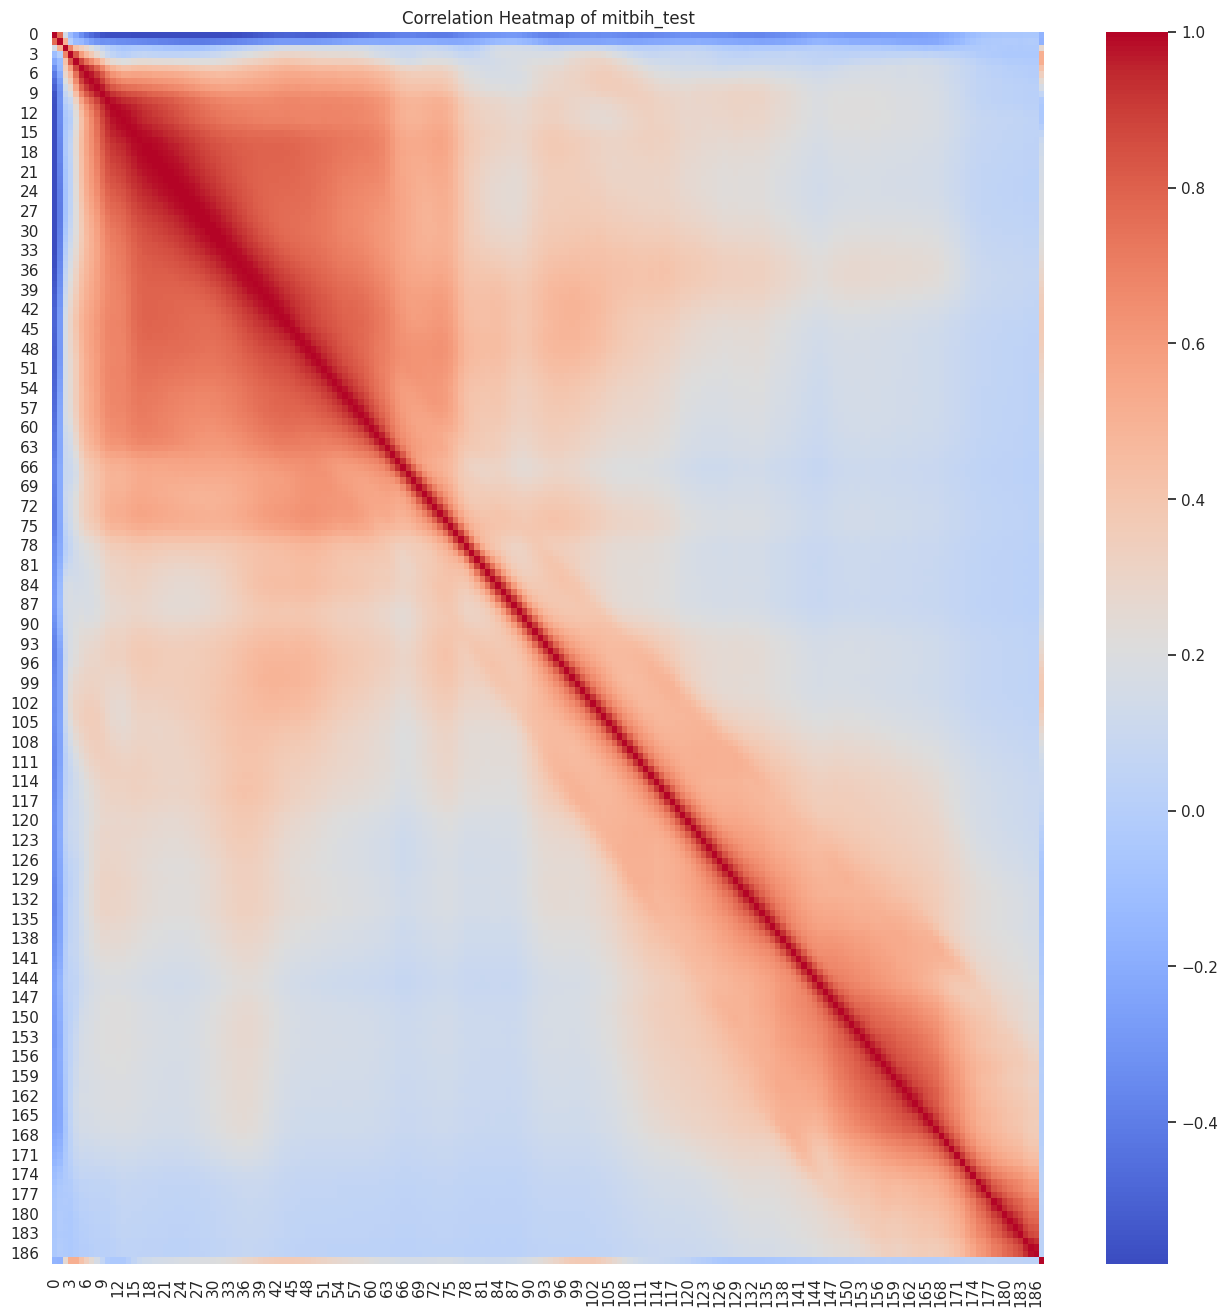

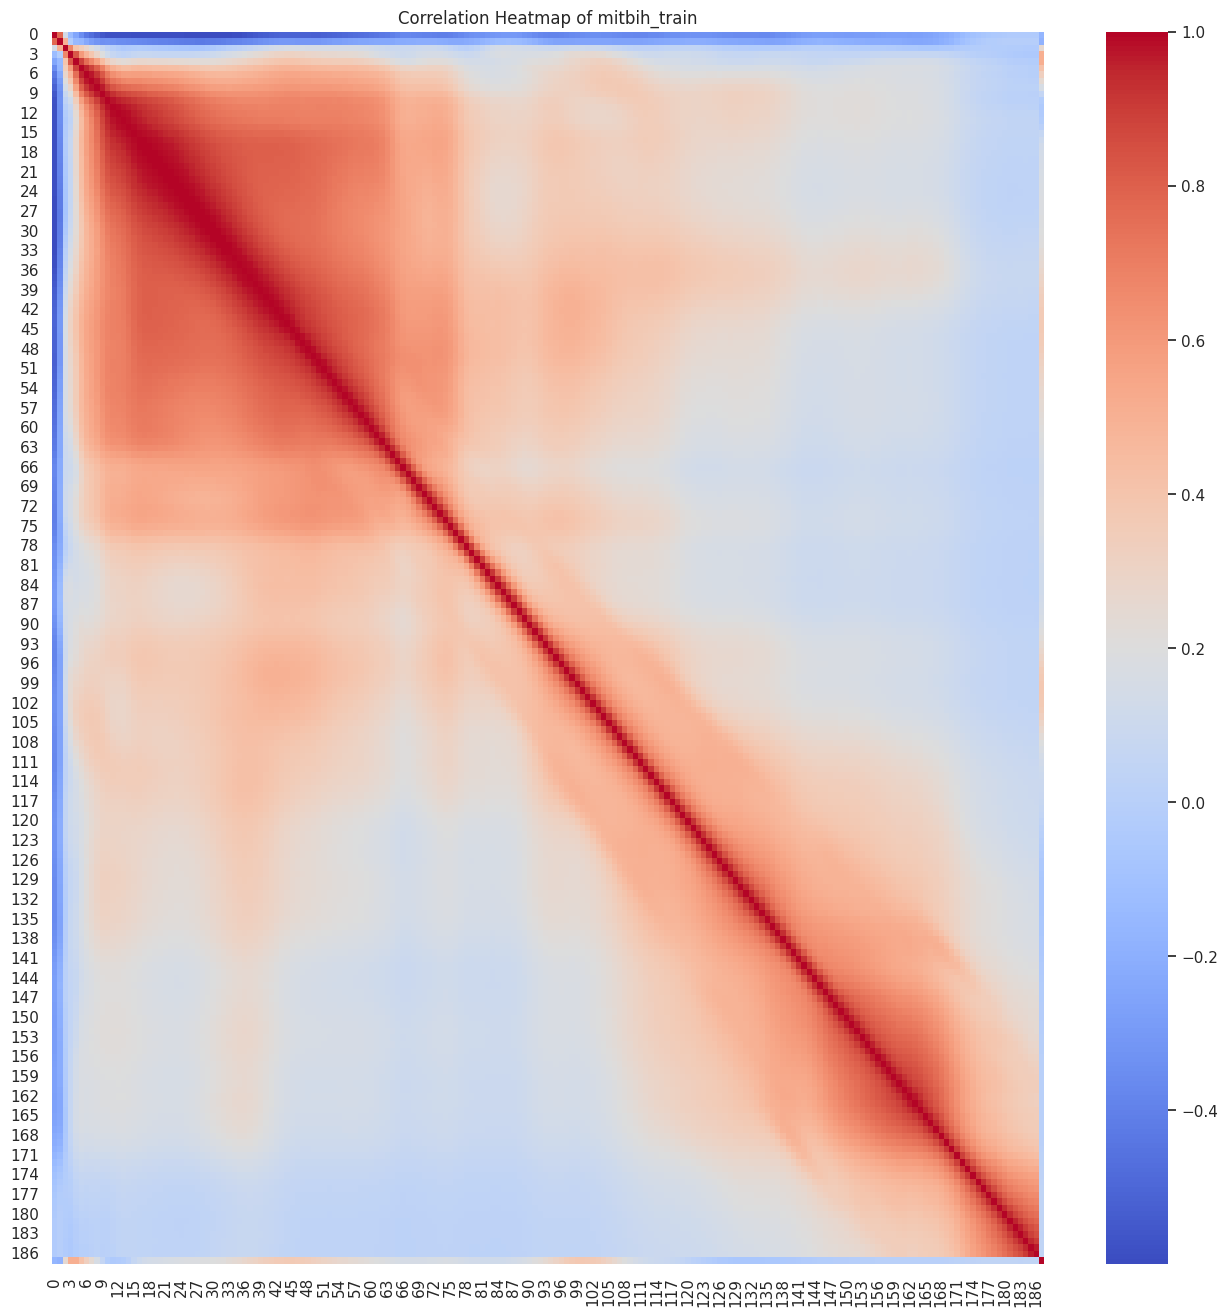

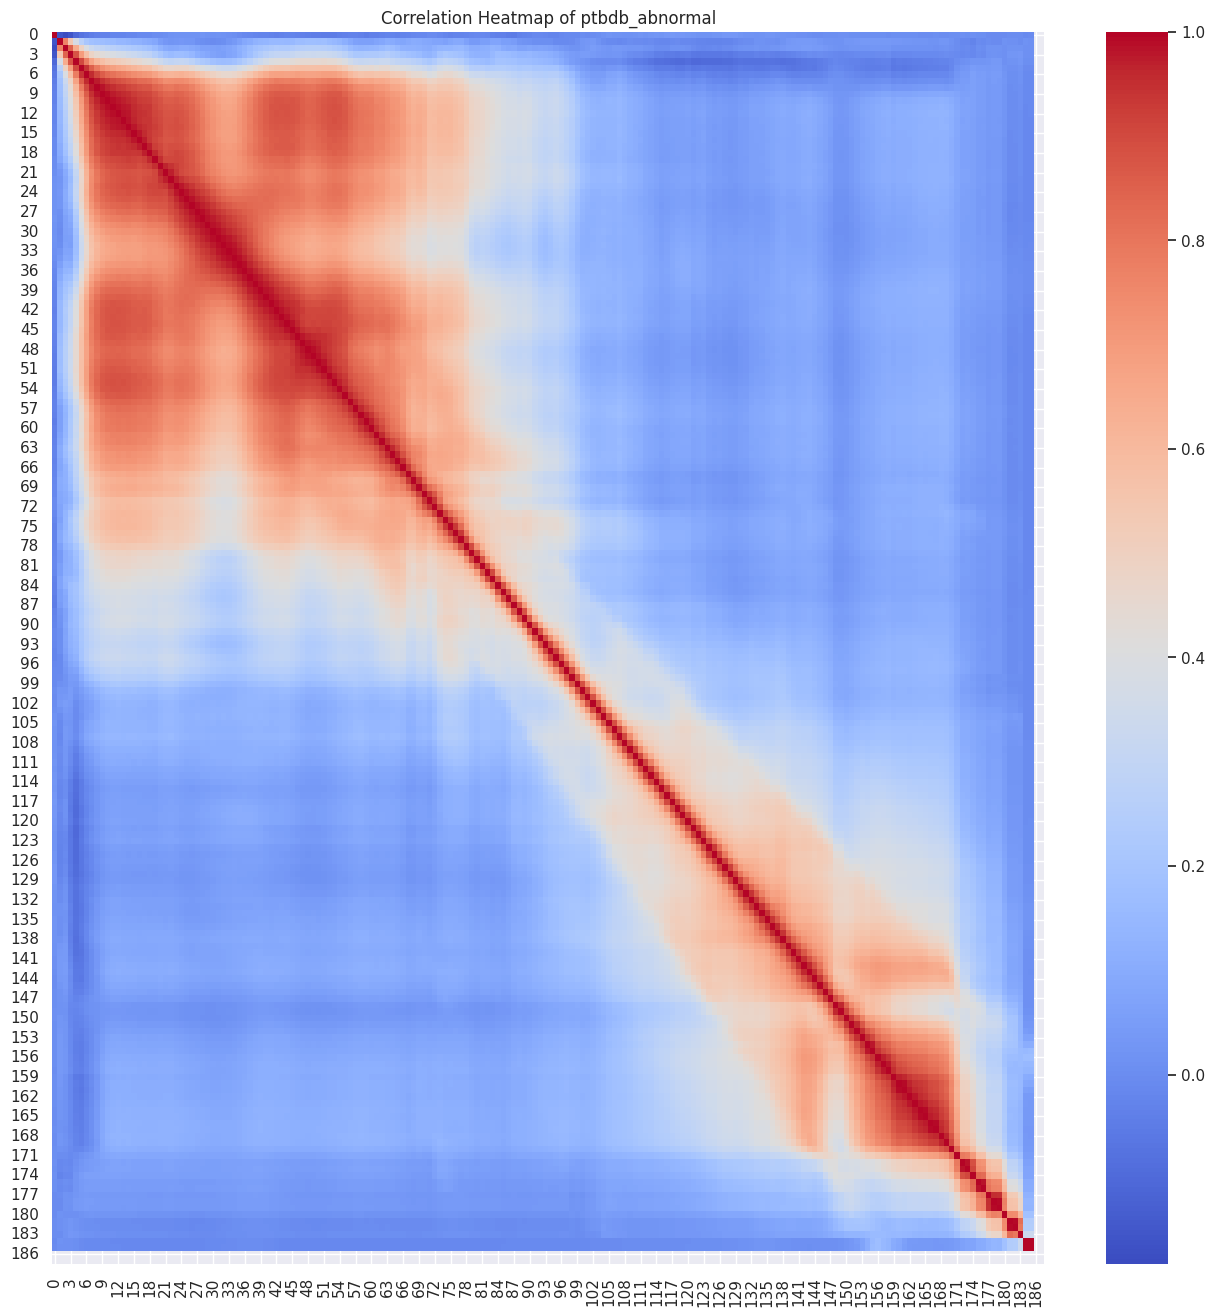

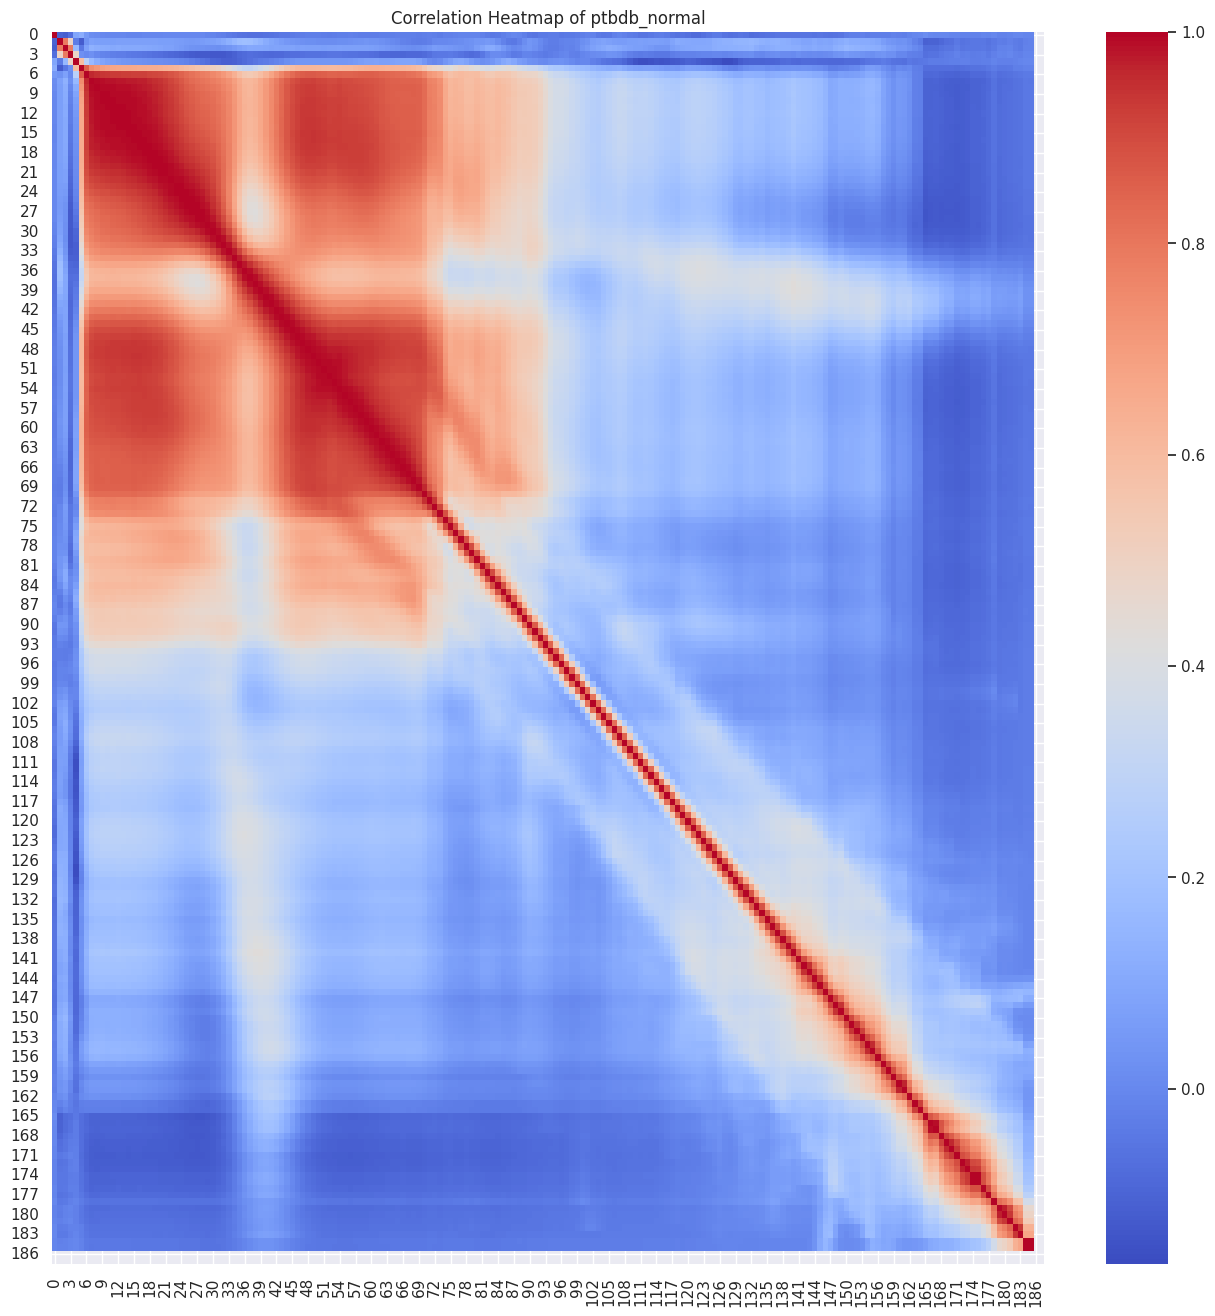

In [25]:
### Tets with function
def analyze_dataframe_corr(df):
    """
    Analyze the given DataFrame.

    Parameters:
        df (DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    # Use DataFrame name if available, otherwise use variable name
    df_name = df.name if hasattr(df, 'name') and df.name is not None else str([name for name, obj in globals().items() if obj is df][0]);
    # Calculate correlation matrix
    correlation_matrix = df.corr();

    # Plot heatmap of correlation matrix
    plt.figure(figsize=(16, 16));
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f");
    plt.title(f'Correlation Heatmap of {df_name}');
    plt.savefig(f"../reports/figures/viz_plots/Correlation_Heatmap_for_df_{df_name}", dpi=300)
    plt.show()
    
    return df;

# examine mitbih_test
analyze_dataframe_corr(mitbih_test);
analyze_dataframe_corr(mitbih_train);

analyze_dataframe_corr(ptbdb_abnormal);
analyze_dataframe_corr(ptbdb_normal);


### 3.3) Identification of outliers with z-score
we identify outliers using a simple Z-score function: values greater 3 or smaller -3 are scored as outliers and summed for each column of a df. The list of Z-scores is plottet against the columns of the df.
all other methods are too time and calculation power consuming.

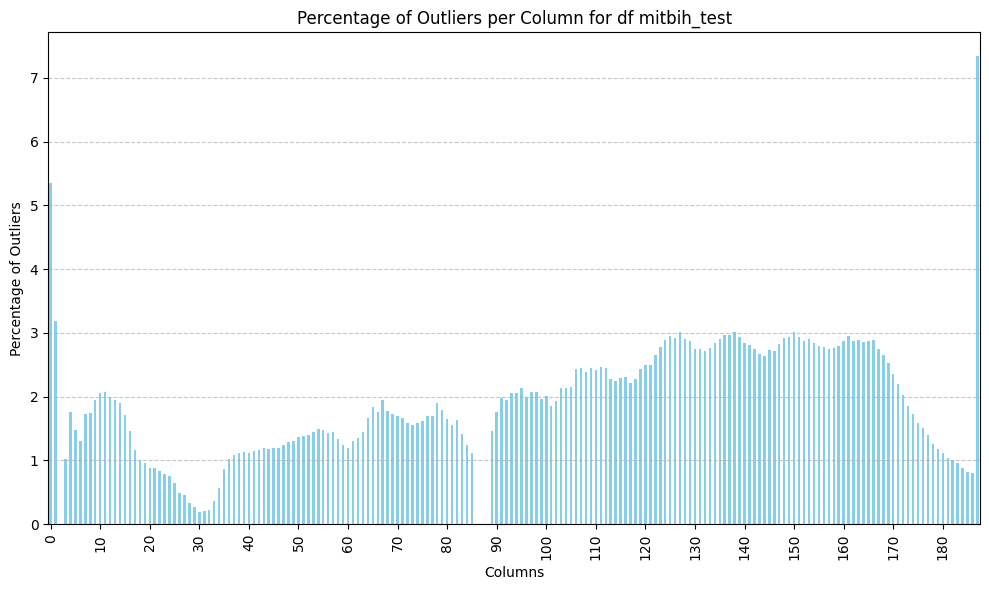

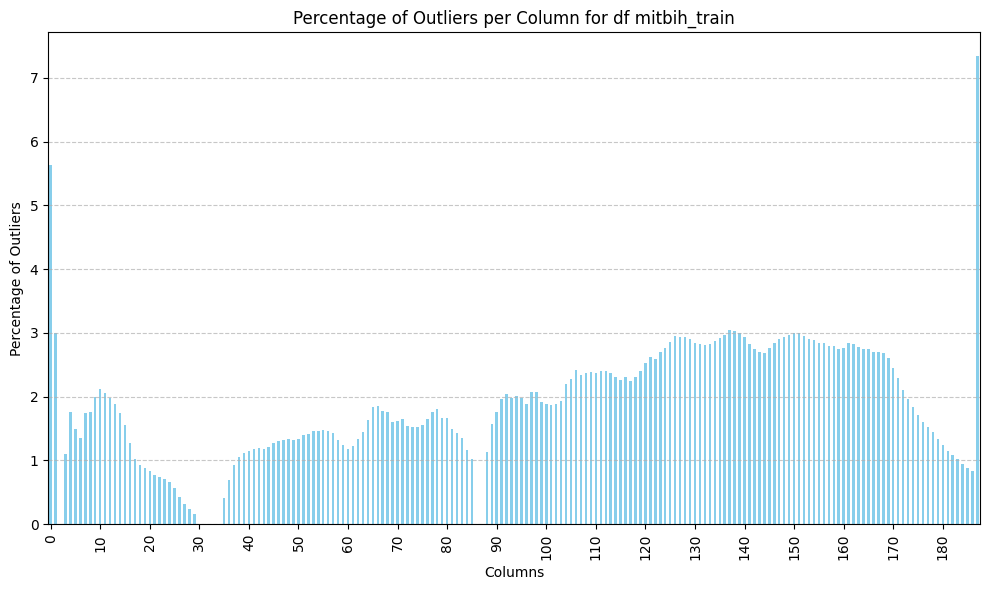

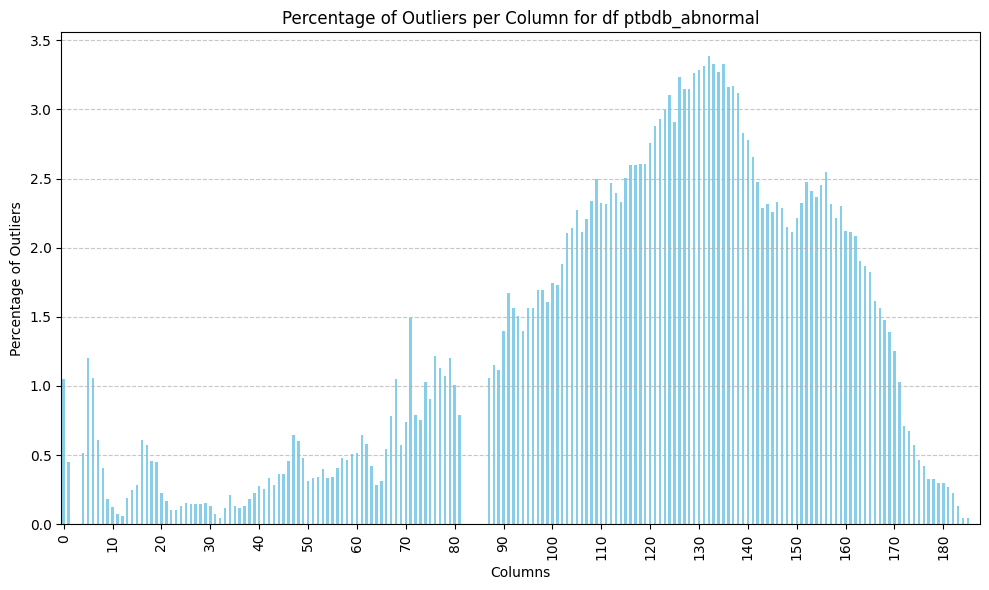

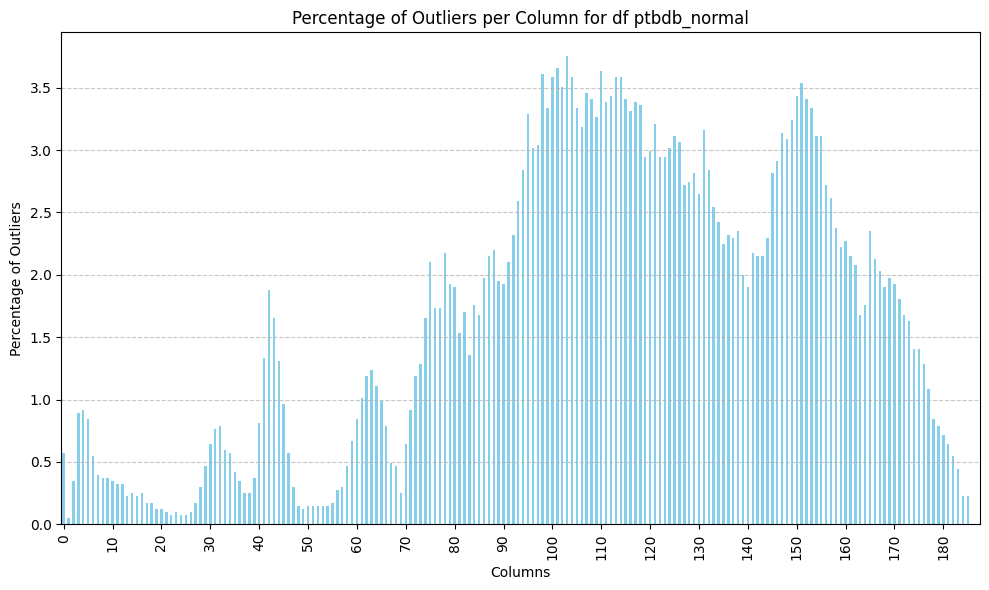

In [12]:
def plot_outliers(df):
    """
    Compute Z-scores for each column of the DataFrame and plot the percentage of outliers per column.

    Parameters:
        df (DataFrame): The DataFrame containing the data.

    Returns:
        None
    """
    df_name = df.name if hasattr(df, 'name') and df.name is not None else str([name for name, obj in globals().items() if obj is df][0]);
    # Compute Z-scores for each column
    z_scores = (df - df.mean()) / df.std()

    # Identify outliers with Z-score greater than 3 or less than -3
    outliers = (z_scores > 3) | (z_scores < -3)

    # Compute the percentage of outliers for each column
    #outliers_percentage = outliers.mean() * 100
    outliers_percentage = outliers.sum() / len(df) *100 #way faster

    # Plot the percentage of outliers for each column
    plt.figure(figsize=(10, 6))
    outliers_percentage.plot(kind='bar', color='skyblue')
    plt.xlabel('Columns')
    plt.ylabel('Percentage of Outliers')
    plt.title(f'Percentage of Outliers per Column for df {df_name}')
    xticks_positions = list(range(0, len(df.iloc[0, :]), 10))
    xticks_labels = [str(x) for x in xticks_positions]
    plt.xticks(xticks_positions, xticks_labels, rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_outliers(mitbih_test)
plot_outliers(mitbih_train)
plot_outliers(ptbdb_abnormal)
plot_outliers(ptbdb_normal)

# Preprocessing

## MITBIH-Datasets:

We can use directly the train set and allocate it to a new variable mitbih_train_a. We have to split the dataframe in X and y for these purpoeses (at least for packages from imblearn). Also we might use a different approach, where only the train set is rebalanced to exakt values (package resample from sklearn.utils). But for now, we use only the learned approaches from the course.
We do not touch the test set!

## PTDBD-Datasets:
Since we do not have a test and train set, we do have to combine the original datasets first, shuffle them in a random order, then generate Test and Train sets and then perform RandomOver- and UnderSampling.


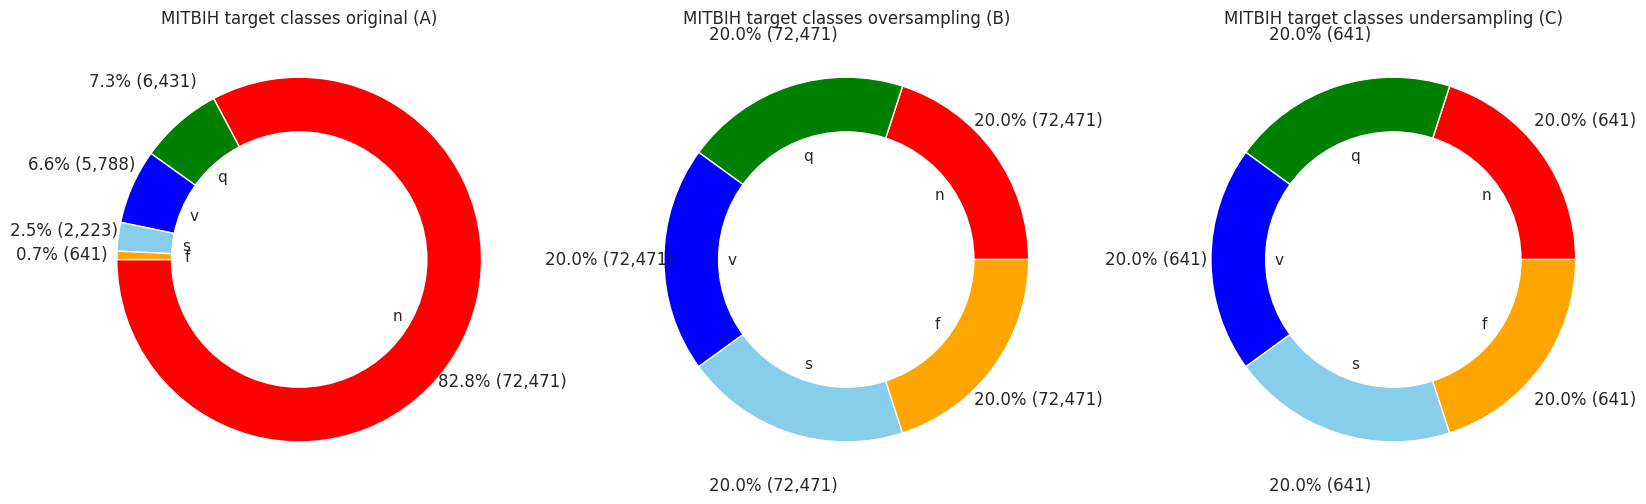

----------------------------------------------------------------------------------------------------------


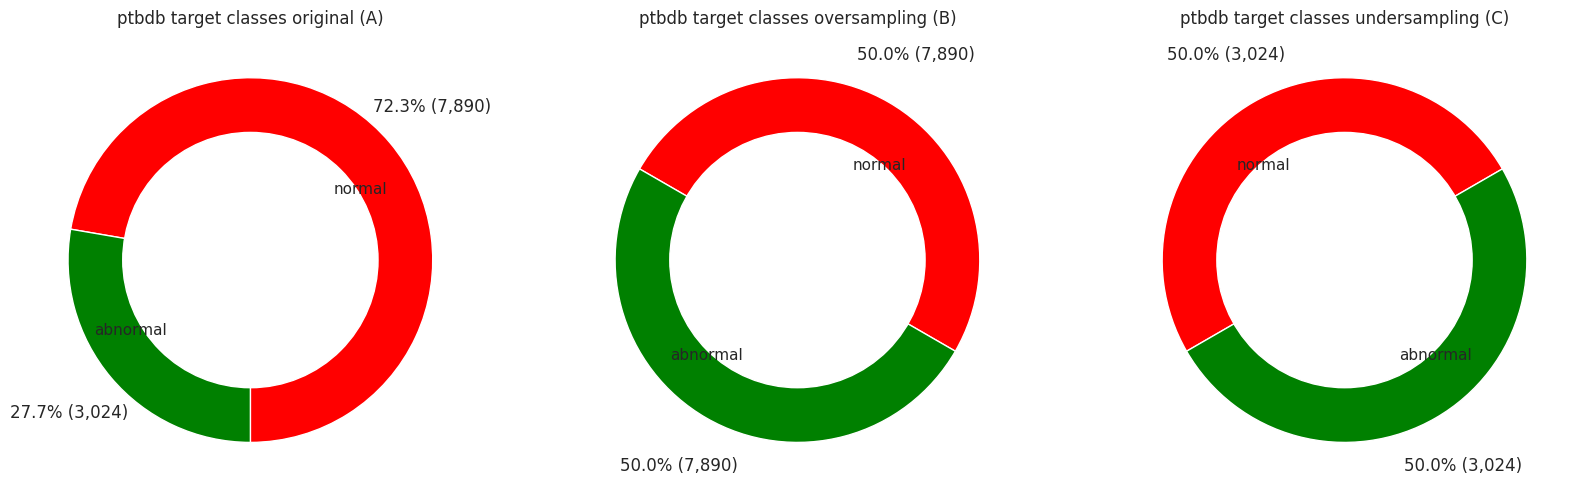

In [26]:
#Mitbih-Code:
#allocating train_set to X and y for comparison purposes:
X_mitbih_train_a = mitbih_train.iloc[:, :-1] #All values except the last column
y_mitbih_train_a = mitbih_train.iloc[:, -1] #all values from last column

X_mitbih_test_a = mitbih_test.iloc[:, :-1] #All values except the last column. MUST NOT BE CHANGED LATER, JUST FOR EVALUATION!
y_mitbih_test_a = mitbih_test.iloc[:, -1] #all values from last column. MUST NOT BE CHANGED LATER, JUST FOR EVALUATION!

#Fitting and resampling with RandomOverSampler (case b)
X_mitbih_train_b, y_mitbih_train_b = RandomOverSampler().fit_resample(X_mitbih_train_a, y_mitbih_train_a)

#Fitting and resampling with RandomUnderSampler (case c)
X_mitbih_train_c, y_mitbih_train_c = RandomUnderSampler().fit_resample(X_mitbih_train_a, y_mitbih_train_a)

# Count values for the target in mitbih_a and calculate percentages
value_counts_train_a = y_mitbih_train_a.value_counts()
percentages_train_a = 100 * value_counts_train_a / len(y_mitbih_train_a)

# Count values for the target in mitbih_b and calculate percentages
value_counts_train_b = y_mitbih_train_b.value_counts()
percentages_train_b = 100 * value_counts_train_b / len(y_mitbih_train_b)

# Count values for the target in mitbih_c and calculate percentages
value_counts_train_c = y_mitbih_train_c.value_counts()
percentages_train_c = 100 * value_counts_train_c / len(y_mitbih_train_c)

plt.figure(figsize=(20, 10)) #plot everything together

# Plot for mitbih_a
plt.subplot(1, 3, 1) 
plt.title("MITBIH target classes original (A)")
my_circle_train = plt.Circle((0, 0), 0.7, color='white')
plt.pie(value_counts_train_a, startangle=180 ,labels=['n', 'q', 'v', 's', 'f'], colors=['red', 'green', 'blue', 'skyblue', 'orange'], pctdistance=1.3, labeldistance=0.6,  autopct=lambda p: '{:.1f}% ({:,.0f})'.format(p, p * sum(value_counts_train_a) / 100))
plt.gca().add_artist(my_circle_train)

# Plot for mitbih_b
plt.subplot(1, 3, 2) 
plt.title("MITBIH target classes oversampling (B)")
my_circle_test = plt.Circle((0, 0), 0.7, color='white')
plt.pie(value_counts_train_b, labels=['n', 'q', 'v', 's', 'f'], colors=['red', 'green', 'blue', 'skyblue', 'orange'], pctdistance=1.3, labeldistance=0.6,  autopct=lambda p: '{:.1f}% ({:,.0f})'.format(p, p * sum(value_counts_train_b) / 100))
plt.gca().add_artist(my_circle_test)

# Plot für mitbih_c
plt.subplot(1, 3, 3)  # dritter Plot in der gleichen Reihe
plt.title("MITBIH target classes undersampling (C)")
my_circle_test = plt.Circle((0, 0), 0.7, color='white')
plt.pie(value_counts_train_c, labels=['n', 'q', 'v', 's', 'f'], colors=['red', 'green', 'blue', 'skyblue', 'orange'], pctdistance=1.3, labeldistance=0.6,  autopct=lambda p: '{:.1f}% ({:,.0f})'.format(p, p * sum(value_counts_train_c) / 100))
plt.gca().add_artist(my_circle_test)
plt.savefig(f"../reports/figures/viz_plots/Difference_between_sampled_datasets_Mitbih", dpi=300)
plt.show()
print("----------------------------------------------------------------------------------------------------------")
#PTDBD-Code:
#Generating one Dataset and shuffling it in random order. We therefore rename the columns of one of the initial dataframes:
ptbdb_abnormal_2 = ptbdb_abnormal
ptbdb_abnormal_2.columns = ptbdb_normal.columns #We now have the same column names in each dataframe that has to be concatenated.
ptbdb_combined = pd.concat([ptbdb_normal, ptbdb_abnormal_2], ignore_index=True, axis=0)

#Reshuffle the whole new dataframe
ptbdb_combined_shuffled = ptbdb_combined.sample(frac=1, random_state=42)

#Generate Test and Train datasets
X_ptbdb_a = ptbdb_combined_shuffled.iloc[:, :-1] #All values except the last column
y_ptbdb_a = ptbdb_combined_shuffled.iloc[:, -1] #All values from the last column

X_ptbdb_train_a, X_ptbdb_test_a, y_ptbdb_train_a, y_ptbdb_test_a = train_test_split(X_ptbdb_a, y_ptbdb_a, test_size=0.25, random_state=42)

#Fitting and resampling with RandomOverSampler (case b)
X_ptbdb_train_b, y_ptbdb_train_b = RandomOverSampler().fit_resample(X_ptbdb_train_a, y_ptbdb_train_a)

#Fitting and resampling with RandomUnderSampler (case c)
X_ptbdb_train_c, y_ptbdb_train_c = RandomUnderSampler().fit_resample(X_ptbdb_train_a, y_ptbdb_train_a)

# Count values for the target in ptbdbb_a and calculate percentages
value_counts_train_a = y_ptbdb_train_a.value_counts()
percentages_train_a = 100 * value_counts_train_a / len(y_ptbdb_train_a)

# Count values for the target in ptbdbb_b and calculate percentages
value_counts_train_b = y_ptbdb_train_b.value_counts()
percentages_train_b = 100 * value_counts_train_b / len(y_ptbdb_train_b)

# Count values for the target in ptbdbb_c and calculate percentages
value_counts_train_c = y_ptbdb_train_c.value_counts()
percentages_train_c = 100 * value_counts_train_c / len(y_ptbdb_train_c)

plt.figure(figsize=(20, 10))  # plot everything together

# Plot for ptbdb_a
plt.subplot(1, 3, 1) 
plt.title("ptbdb target classes original (A)")
my_circle_train = plt.Circle((0, 0), 0.7, color='white')
plt.pie(value_counts_train_a, startangle=270 ,labels=['normal', 'abnormal'], colors=['red', 'green'], pctdistance=1.3, labeldistance=0.6,  autopct=lambda p: '{:.1f}% ({:,.0f})'.format(p, p * sum(value_counts_train_a) / 100))
plt.gca().add_artist(my_circle_train)

# Plot for ptbdb_b
plt.subplot(1, 3, 2)
plt.title("ptbdb target classes oversampling (B)")
my_circle_test = plt.Circle((0, 0), 0.7, color='white')
plt.pie(value_counts_train_b, startangle=-30 ,labels=['normal', 'abnormal'], colors=['red', 'green'], pctdistance=1.3, labeldistance=0.6,  autopct=lambda p: '{:.1f}% ({:,.0f})'.format(p, p * sum(value_counts_train_b) / 100))
plt.gca().add_artist(my_circle_test)

# Plot for ptbdb_c
plt.subplot(1, 3, 3) 
plt.title("ptbdb target classes undersampling (C)")
my_circle_test = plt.Circle((0, 0), 0.7, color='white')
plt.pie(value_counts_train_c, startangle=30 , labels=['normal', 'abnormal'], colors=['red', 'green'], pctdistance=1.3, labeldistance=0.6,  autopct=lambda p: '{:.1f}% ({:,.0f})'.format(p, p * sum(value_counts_train_c) / 100))
plt.gca().add_artist(my_circle_test)
plt.savefig(f"../reports/figures/viz_plots/Difference_between_sampled_datasets_Ptbdb", dpi=300)
plt.show()


## Recheck for normal distribution

NOT SURE IF THIS IS CORRECT, RECHECK WITH ALEX NOTEBOOK!

Shapiro statistics for X_ptbdb_train_a


/tmp/ipykernel_146107/792273779.py:8: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10914.
  shapiro_stat, shapiro_p = shapiro(df.iloc[: , col])
/tmp/ipykernel_146107/792273779.py:8: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  shapiro_stat, shapiro_p = shapiro(df.iloc[: , col])


Count of single unique values,count
Values of shapiro statistic,
0.009091,1
0.009243,1
0.015449,1
0.022217,1
0.024487,1
...,...
0.964893,1
0.964921,1
0.966918,1


Count of single unique values,count
Values of shapiro p value,
0.0,186
1.0,1


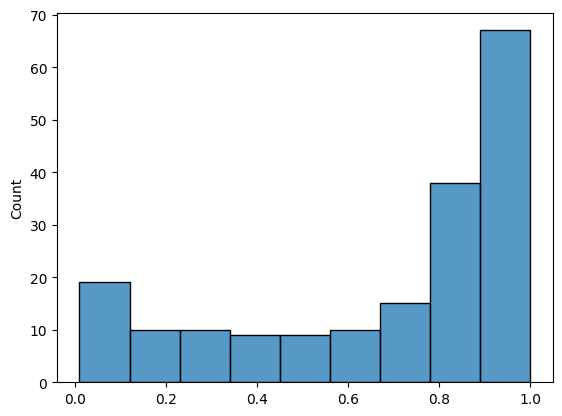

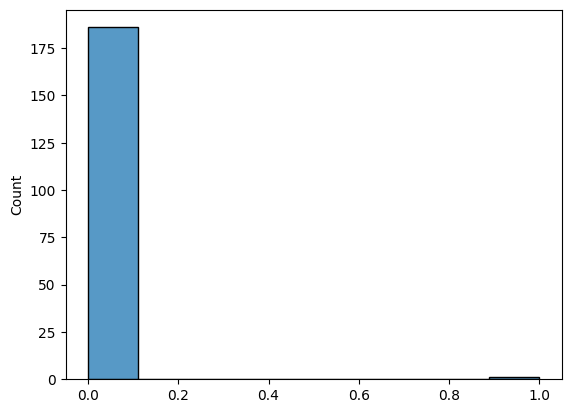

/tmp/ipykernel_146107/792273779.py:8: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15780.
  shapiro_stat, shapiro_p = shapiro(df.iloc[: , col])
/tmp/ipykernel_146107/792273779.py:8: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  shapiro_stat, shapiro_p = shapiro(df.iloc[: , col])


Shapiro statistics for X_ptbdb_train_b


Count of single unique values,count
Values of shapiro statistic,
0.014152,1
0.014390,1
0.023936,1
0.031126,1
0.034034,1
...,...
0.970188,1
0.974715,1
0.975207,1


Count of single unique values,count
Values of shapiro p value,
0.0,186
1.0,1


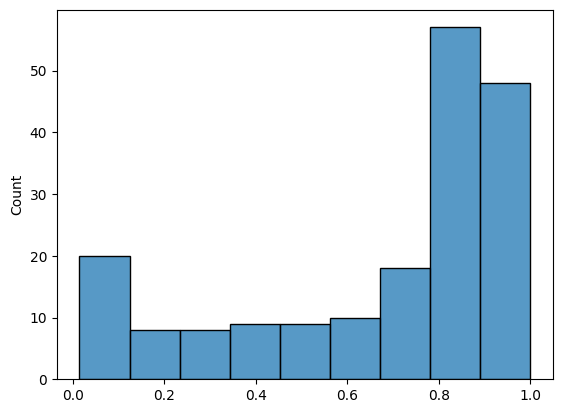

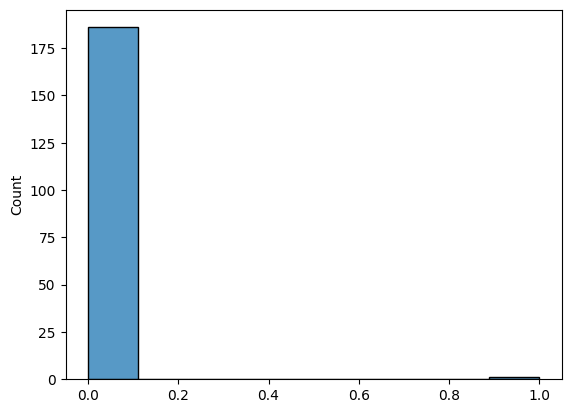

Shapiro statistics for X_ptbdb_train_c


/tmp/ipykernel_146107/792273779.py:8: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6048.
  shapiro_stat, shapiro_p = shapiro(df.iloc[: , col])
/tmp/ipykernel_146107/792273779.py:8: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  shapiro_stat, shapiro_p = shapiro(df.iloc[: , col])


Count of single unique values,count
Values of shapiro statistic,
0.011382,1
0.011617,1
0.019580,1
0.027192,1
0.029976,1
...,...
0.970293,1
0.974102,1
0.974773,1


Count of single unique values,count
Values of shapiro p value,
0.0,186
1.0,1


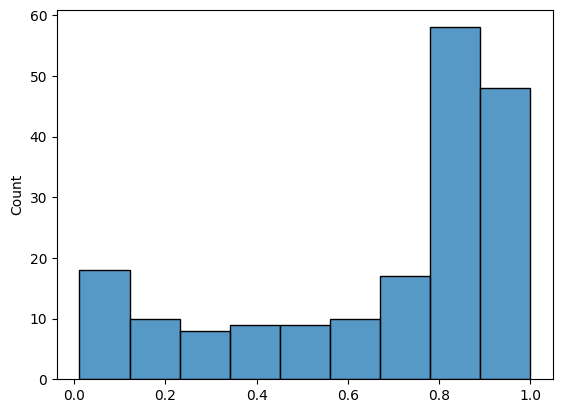

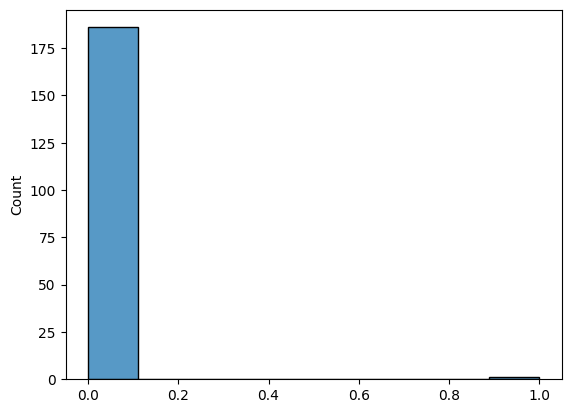

In [14]:
#Using only a histogram

def shapiro_stats(df):
    df_name = df.name if hasattr(df, 'name') and df.name is not None else str([name for name, obj in globals().items() if obj is df][0])
    shapiro_stats = []
    shapiro_ps = []
    for col in range(len(df.columns)):
        shapiro_stat, shapiro_p = shapiro(df.iloc[: , col])
        #sns.histplot(data=mitbih_train, x=mitbih_train.iloc[:5000, col])
        #print(f"shapiro statistic value: {shapiro_stat}. Shapiro p-value: {shapiro_p}")
        #plt.show()
        shapiro_stats.append(round(shapiro_stat, 20))
        shapiro_ps.append(round(shapiro_p, 20))
    print(f"Shapiro statistics for {df_name}")
    display(pd.crosstab(shapiro_stats, "count", colnames=["Count of single unique values"], rownames=["Values of shapiro statistic"]))
    display(pd.crosstab(shapiro_ps, "count", colnames=["Count of single unique values"], rownames=["Values of shapiro p value"]))
    sns.histplot(data=shapiro_stats)
    #plt.savefig(f"../reports/figures/viz_plots/Shapiro_stats_plot_for_df_{df_name}", dpi=300)
    plt.show()
    sns.histplot(data=shapiro_ps)
    #plt.savefig(f"../reports/figures/viz_plots/Shapiro_pvalues_plot_for_df_{df_name}", dpi=300)
    plt.show()

shapiro_stats(X_ptbdb_train_a)
shapiro_stats(X_ptbdb_train_b)
shapiro_stats(X_ptbdb_train_c)


We see now, that the data is not normal distributed in all cases. We could try to map it to normal distribution, then parametrical tests and models would be more applicable.

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.801729,0.733941,0.867698,0.476182,-0.216609,-0.462934,-0.524828,-0.685582,-0.631108,-0.773924,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701
1,0.801729,0.937401,1.197948,0.314139,-0.462125,0.059235,0.056283,-0.406262,-0.584047,-0.543117,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701
2,0.801729,-0.443027,-1.069232,-0.330549,-0.090059,-0.028030,0.117752,0.087728,0.184286,0.335638,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701
3,0.801729,1.306105,0.381184,0.353187,0.354592,0.284497,-0.053389,-0.071792,-0.391923,-0.497434,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701
4,-1.456866,-1.577147,-2.013036,-1.002567,-0.776243,-0.981028,-0.755373,-0.546244,-0.666822,-0.464698,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,0.801729,-0.861261,0.541981,1.202891,1.425870,1.479375,1.485027,1.417941,1.020000,0.662639,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701
3201,0.801729,0.723376,1.165193,1.276911,1.186886,0.708755,0.227820,-0.292345,-0.858471,-1.242303,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701
3202,-0.112929,-1.143932,0.164012,0.862622,1.184059,1.231009,1.301516,1.281546,1.086480,0.876647,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701
3203,0.120322,0.557734,1.305002,1.539808,1.552688,1.463783,1.283514,1.022171,0.568508,0.258982,...,-0.2208,-0.216096,-0.208062,-0.204785,-0.200615,-0.19551,-0.19291,-0.189405,-0.188456,-0.186701


before:


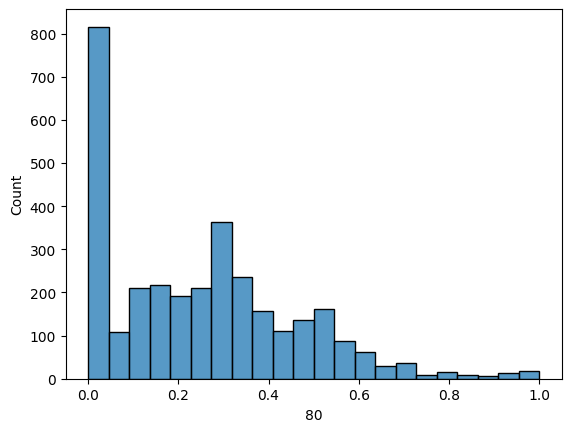

after:


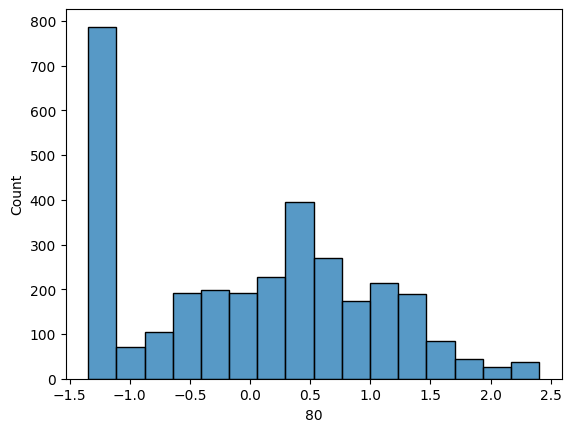

Shapiro statistics for X_mitbih_train_c_normal_bc


Count of single unique values,count
Values of shapiro statistic,
0.172373,1
0.174526,1
0.175525,1
0.179809,1
0.182909,1
...,...
0.988720,1
0.988742,1
0.988946,1


Count of single unique values,count
Values of shapiro p value,
0.000000e+00,159
1.000000e-20,3
2.000000e-20,1
2.300000e-19,2
4.900000e-19,1
6.800000e-19,1
7.000000e-19,1
1.080000e-18,1
4.120000e-18,1


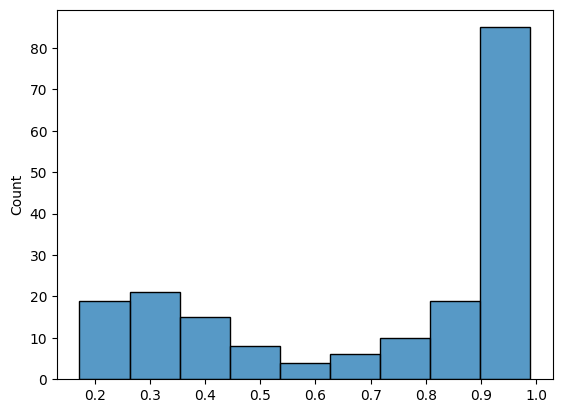

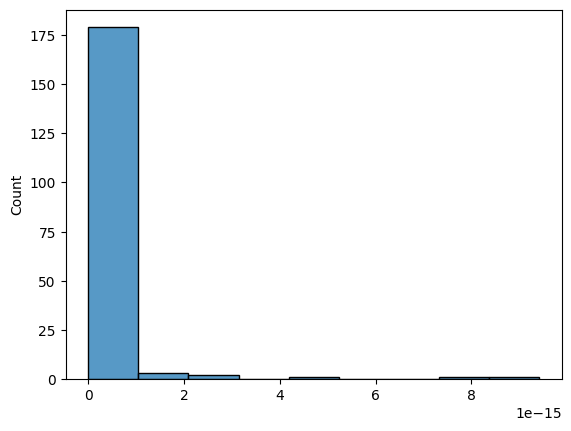

In [15]:
# Map Data to a normal distribution.
bc = PowerTransformer(method="box-cox") #only for positive values
yj = PowerTransformer(method="yeo-johnson")


#perform power transformations:
X_mitbih_train_c_normal_bc = pd.DataFrame(yj.fit_transform(X_mitbih_train_c))
display(X_mitbih_train_c_normal_bc)
print("before:")
sns.histplot(data=X_mitbih_train_c, x=X_mitbih_train_c.iloc[:, 80])
plt.show()
print("after:")
sns.histplot(data=X_mitbih_train_c_normal_bc, x=X_mitbih_train_c_normal_bc.iloc[:, 80])
plt.show()
#use shapiro stats for testing:
shapiro_stats(X_mitbih_train_c_normal_bc)

# Data vizualization AFTER MODELING STAGES (for final report)
this functions are only used on the final csv files which were generated by hand from our summary excel file.
Since they cannot be downloaded, we included them in a special folder inside the notebooks folder, so they are pushed onto the repo.

In [16]:
results_df_mitbih_ML_MODELS = pd.read_csv("result_csv_files/Results_simple_Models_no_gridsearch_mitbih.csv", sep="\t")
print("Result DF for mitbih ML_MODELS (Only weighted averages)")
display(results_df_mitbih_ML_MODELS)

results_df_ptbdb_ML_MODELS = pd.read_csv("result_csv_files/Results_simple_Models_no_gridsearch_ptbdb.csv", sep="\t")
print("Result DF for ptbdb ML_MODELS (Only weighted averages)")
display(results_df_ptbdb_ML_MODELS)

results_df_mitbih_DL_MODELS = pd.read_csv("result_csv_files/Results_DL_Models_Mitbih.csv", sep="\t")
print("Result DF for mitbih DL_MODELS (Only weighted averages)")
display(results_df_mitbih_DL_MODELS)

results_df_ptbdb_DL_MODELS = pd.read_csv("result_csv_files/Results_DL_Models_ptbdb.csv", sep="\t")
print("Result DF for ptbdb DL_MODELS (Only weighted averages)")
display(results_df_ptbdb_DL_MODELS)

Result DF for mitbih ML_MODELS (Only weighted averages)


,Method,Precision,Recall,F1,Accuracy,DATASET
0,SVM,0.9676,0.9680,0.9657,0.9680,Mitbih A
1,KNN,0.9727,0.9736,0.9725,0.9736,Mitbih A
2,Decision Tree,0.9548,0.9548,0.9548,0.9548,Mitbih A
3,Random Forest,0.9745,0.9746,0.9729,0.9746,Mitbih A
4,XGB,0.9804,0.9808,0.9799,0.9808,Mitbih A
5,SVM,0.9629,0.9366,0.9462,0.9366,Mitbih B (SMOTE)
6,KNN,0.9660,0.9551,0.9590,0.9551,Mitbih B (SMOTE)
7,Decision Tree,0.9499,0.9402,0.9439,0.9402,Mitbih B (SMOTE)
8,Random Forest,0.9806,0.9811,0.9808,0.9811,Mitbih B (SMOTE)
9,XGB,0.9727,0.9684,0.9700,0.9684,Mitbih B (SMOTE)


Result DF for ptbdb ML_MODELS (Only weighted averages)


,Method,Precision,Recall,F1,Accuracy,DATASET
0,SVM,0.9126,0.9138,0.9126,0.9138,Ptbdb A
1,KNN,0.9339,0.9320,0.9326,0.9320,Ptbdb A
2,Decision Tree,0.9283,0.9285,0.9284,0.9285,Ptbdb A
3,Random Forest,0.9740,0.9739,0.9736,0.9739,Ptbdb A
4,XGB,0.9797,0.9797,0.9797,0.9797,Ptbdb A
5,SVM,0.9159,0.9045,0.9070,0.9045,Ptbdb B (SMOTE)
6,KNN,0.9322,0.9206,0.9228,0.9206,Ptbdb B (SMOTE)
7,Decision Tree,0.9215,0.9200,0.9205,0.9200,Ptbdb B (SMOTE)
8,Random Forest,0.9759,0.9760,0.9759,0.9760,Ptbdb B (SMOTE)
9,XGB,0.9763,0.9763,0.9763,0.9763,Ptbdb B (SMOTE)


Result DF for mitbih DL_MODELS (Only weighted averages)


,Method,Precision,Recall,F1,Accuracy,DATASET
0,Simple ANN - 1,0.9770,0.9784,0.9778,0.9784,Mitbih A
1,Simple ANN - 2,0.9759,0.9767,0.9761,0.9767,Mitbih A
2,Simple ANN - 3,0.9738,0.9746,0.9730,0.9746,Mitbih A
3,Simple ANN - 4,0.9770,0.9785,0.9779,0.9785,Mitbih A
4,Simple ANN - 1,0.9650,0.9482,0.9544,0.9482,Mitbih B
5,Simple ANN - 2,0.9702,0.9671,0.9683,0.9671,Mitbih B
6,Simple ANN - 3,0.9698,0.9684,0.9690,0.9684,Mitbih B
7,Simple ANN - 4,0.9716,0.9704,0.9709,0.9704,Mitbih B
8,Simple CNN - 1,0.9787,0.9794,0.9787,0.9794,Mitbih A
9,Simple CNN - 2,0.9780,0.9788,0.9782,0.9788,Mitbih A


Result DF for ptbdb DL_MODELS (Only weighted averages)


,Method,Precision,Recall,F1,Accuracy,DATASET
0,Simple ANN - 1,0.9654,0.9643,0.9646,0.9643,PTBDB A
1,Simple ANN - 2,0.9445,0.9437,0.9440,0.9437,PTBDB A
2,Simple ANN - 3,0.9593,0.9588,0.9590,0.9588,PTBDB A
3,Simple ANN - 4,0.9667,0.9667,0.9667,0.9667,PTBDB A
4,Simple ANN - 1,0.9725,0.9725,0.9725,0.9725,PTBDB B
5,Simple ANN - 2,0.9566,0.9564,0.9565,0.9564,PTBDB B
6,Simple ANN - 3,0.9573,0.9574,0.9574,0.9574,PTBDB B
7,Simple ANN - 4,0.9663,0.9660,0.9661,0.9660,PTBDB B
8,Simple CNN - 1,0.9775,0.9773,0.9774,0.9773,PTBDB A
9,Simple CNN - 2,0.9804,0.9804,0.9804,0.9804,PTBDB A


In [17]:
#Function for the plots that are used in the reports to compare our models across the different datasets / experiments.
def plot_lineplot(data, x, y, hue, style, markers=True, dashes=False, palette='deep', xlabel=None, ylabel=None, legend_title=None, legend_loc='upper right', figsize=(12, 8), title="", filename=None):
    """
    Plot a lineplot with customizable parameters.

    Parameters:
    - data: DataFrame, the data to plot.
    - x: str, the column name for the x-axis.
    - y: str, the column name for the y-axis.
    - hue: str, the column name for the hue (color).
    - style: str, the column name for the line style.
    - markers: bool, whether to show markers on the lines (default is True).
    - dashes: bool, whether to show dashed lines (default is False).
    - palette: str or dict, the color palette to use (default is 'deep').
    - xlabel: str, label for the x-axis (default is None).
    - ylabel: str, label for the y-axis (default is None).
    - legend_title: str, title for the legend (default is None).
    - legend_loc: str, location for the legend (default is 'upper right').
    - figsize: tuple, the size of the figure (default is (12, 8)).
    """
    plt.figure(figsize=figsize)
    sns.set_theme(style="darkgrid")

    ax = sns.lineplot(
        x=x,
        y=y,
        hue=hue,
        style=style,
        data=data,
        markers=markers,
        dashes=dashes,
        palette=palette,
    )

    if xlabel:
        ax.set(xlabel=xlabel)
    if ylabel:
        ax.set(ylabel=ylabel)
    if legend_title:
        plt.legend(title=legend_title, loc=legend_loc)
    else:
        plt.legend(loc=legend_loc)
    plt.title(title)
    plt.xticks(rotation=90)
    
    if filename:
        plt.savefig("../reports/figures/result_plots/" + filename, dpi=300, bbox_inches='tight')

    plt.show()

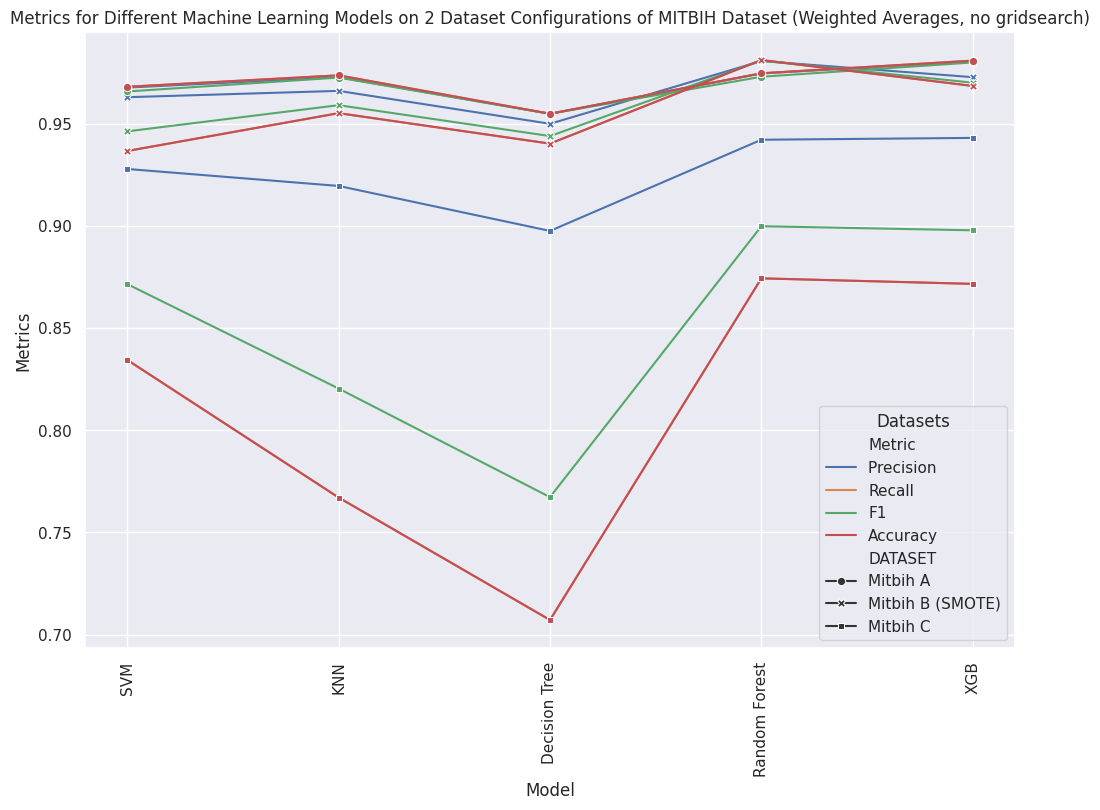

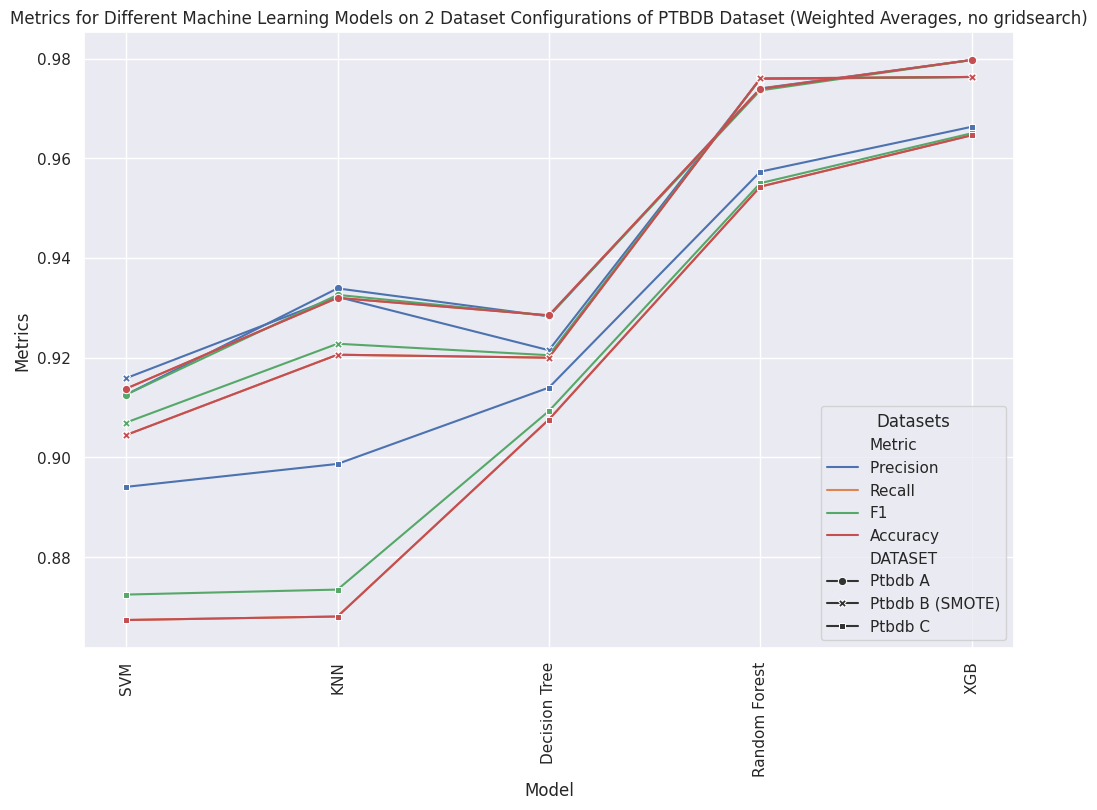

In [18]:
#plots for mitbih and ptbdb results (weighted averages) in the simple machine learning section
plot_lineplot(
    data=pd.melt(results_df_mitbih_ML_MODELS, id_vars=['Method', 'DATASET'], var_name='Metric', value_name='Value'),
    x='Method',
    y='Value',
    hue='Metric',
    style='DATASET',
    markers=True,
    dashes=False,
    palette='deep',
    xlabel='Model',
    ylabel='Metrics',
    legend_title='Datasets',
    legend_loc='lower right',
    figsize=(12, 8),
    title="Metrics for Different Machine Learning Models on 2 Dataset Configurations of MITBIH Dataset (Weighted Averages, no gridsearch)",
    filename="Mitbih results ML models weighted averages"
)

plot_lineplot(
    data=pd.melt(results_df_ptbdb_ML_MODELS, id_vars=['Method', 'DATASET'], var_name='Metric', value_name='Value'),
    x='Method',
    y='Value',
    hue='Metric',
    style='DATASET',
    markers=True,
    dashes=False,
    palette='deep',
    xlabel='Model',
    ylabel='Metrics',
    legend_title='Datasets',
    legend_loc='lower right',
    figsize=(12, 8),
    title="Metrics for Different Machine Learning Models on 2 Dataset Configurations of PTBDB Dataset (Weighted Averages, no gridsearch)",
    filename="Ptbdb results ML models weighted averages"
)

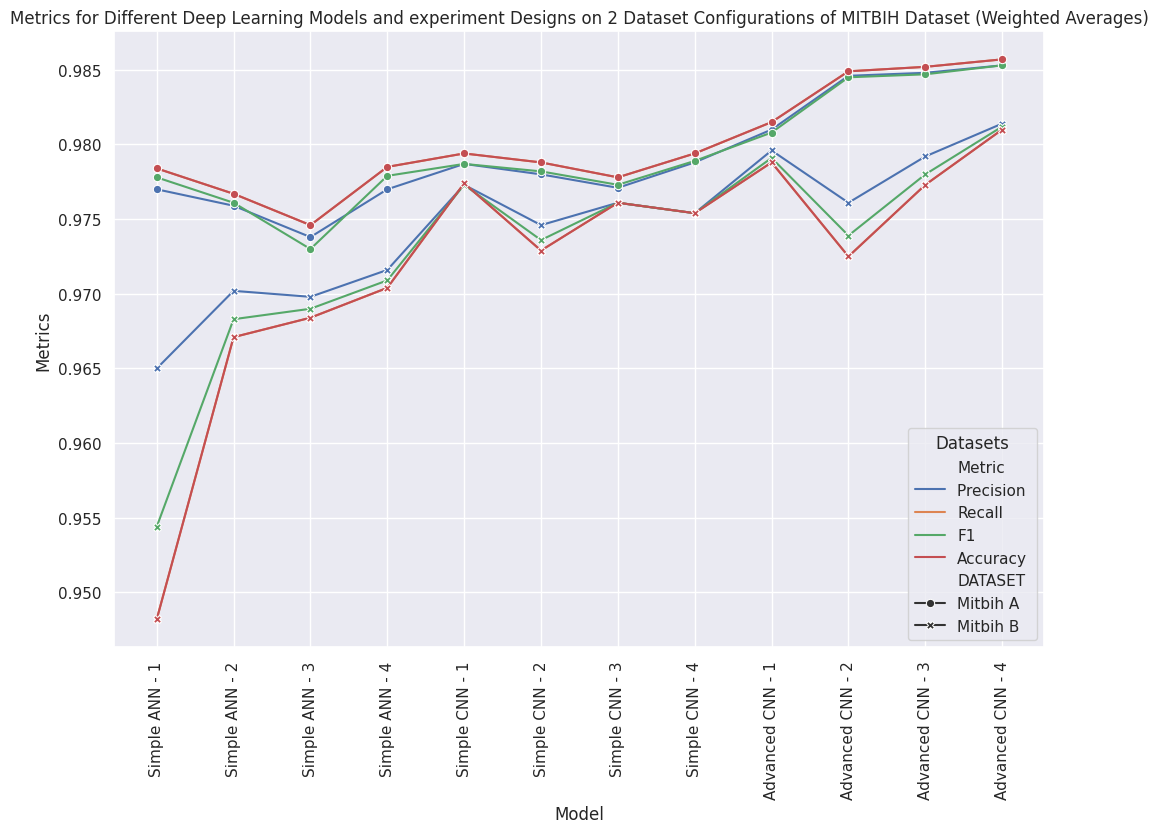

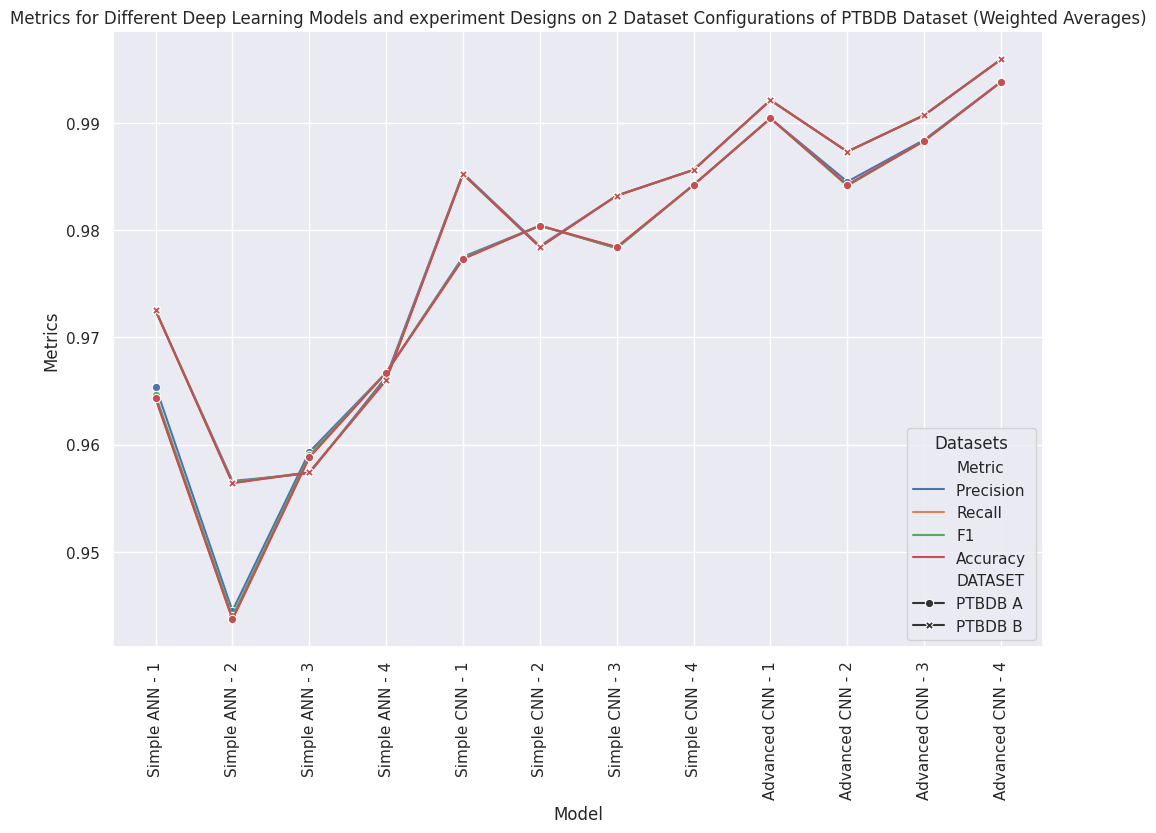

In [19]:
#plots for mitbih and ptbdb results (weighted averages) in the deep learning section
plot_lineplot(
    data=pd.melt(results_df_mitbih_DL_MODELS, id_vars=['Method', 'DATASET'], var_name='Metric', value_name='Value'),
    x='Method',
    y='Value',
    hue='Metric',
    style='DATASET',
    markers=True,
    dashes=False,
    palette='deep',
    xlabel='Model',
    ylabel='Metrics',
    legend_title='Datasets',
    legend_loc='lower right',
    figsize=(12, 8),
    title="Metrics for Different Deep Learning Models and experiment Designs on 2 Dataset Configurations of MITBIH Dataset (Weighted Averages)",
    filename="Mitbih results DL models weighted averages"
)

plot_lineplot(
    data=pd.melt(results_df_ptbdb_DL_MODELS, id_vars=['Method', 'DATASET'], var_name='Metric', value_name='Value'),
    x='Method',
    y='Value',
    hue='Metric',
    style='DATASET',
    markers=True,
    dashes=False,
    palette='deep',
    xlabel='Model',
    ylabel='Metrics',
    legend_title='Datasets',
    legend_loc='lower right',
    figsize=(12, 8),
    title="Metrics for Different Deep Learning Models and experiment Designs on 2 Dataset Configurations of PTBDB Dataset (Weighted Averages)",
    filename="Ptbdb results DL models weighted averages"
)

## Difference between gridsearch and no gridsearch
The following code just takes the weighted average results of a run with default settings for each classifier and one with the best results of the gridsearch for each classifier. The results are only shown for the MITBIH A Dataset. We put the values in here by hand due to time limitations and since we only needed it once.

/tmp/ipykernel_146107/1296017334.py:45: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_combined, x='Method', y=metric, hue='Gridsearch', palette=colors, edgecolor="k", ax=ax)
/tmp/ipykernel_146107/1296017334.py:45: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_combined, x='Method', y=metric, hue='Gridsearch', palette=colors, edgecolor="k", ax=ax)
/tmp/ipykernel_146107/1296017334.py:45: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_combined, x='Method', y=metric, hue='Gridsearch', palette=colors, edgecolor="k", ax=ax)
/tmp/ipykernel_146107/1296017334.py:45: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_combined, x='Method', y=metric, hue='Gridsearch', palette=colors, edgecolor="k", ax=ax)


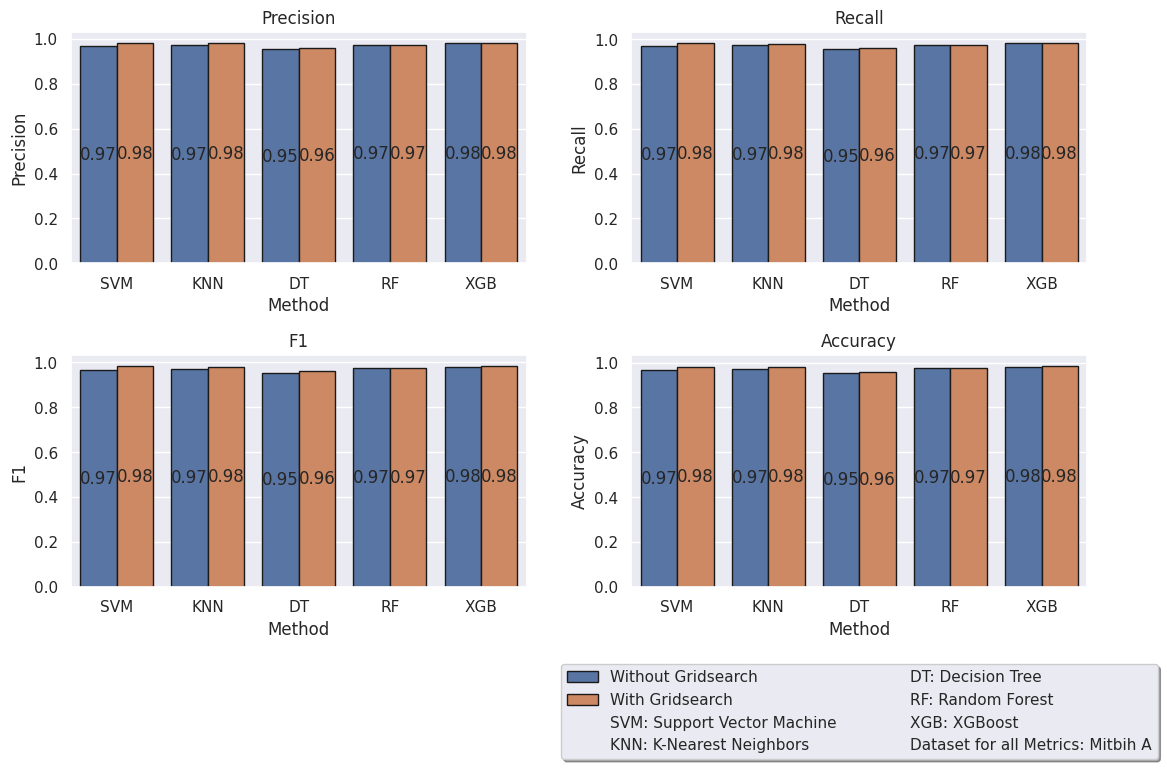

In [20]:
# Original values without gridsearch
data_normal = {
    'Method': ['SVM', 'KNN', 'DT', 'RF', 'XGB'],
    'Precision': [0.9676, 0.9727, 0.9548, 0.9745, 0.9804],
    'Recall': [0.968, 0.9736, 0.9548, 0.9746, 0.9808],
    'F1': [0.9657, 0.9725, 0.9548, 0.9729, 0.9799],
    'Accuracy': [0.968, 0.9736, 0.9548, 0.9746, 0.9808]
}

# Values with gridsearch
data_gridsearch = {
    'Method': ['SVM', 'KNN', 'DT', 'RF', 'XGB'],
    'Precision': [0.982, 0.98, 0.96, 0.975, 0.982],
    'Recall': [0.982, 0.98, 0.96, 0.975, 0.983],
    'F1': [0.982, 0.98, 0.96, 0.973, 0.982],
    'Accuracy': [0.982, 0.98, 0.96, 0.975, 0.983]
}

# make dfs out of values
df_normal = pd.DataFrame(data_normal)
df_gridsearch = pd.DataFrame(data_gridsearch)

# concat dfs and sign where gridsearch was used and where not.
df_normal['Gridsearch'] = 'Without Gridsearch'
df_gridsearch['Gridsearch'] = 'With Gridsearch'
df_combined = pd.concat([df_normal, df_gridsearch], ignore_index=True)

# Make it beautiful
colors = sns.color_palette("deep")

# Use dict to name the models later
legend_dict = {
    'SVM': 'Support Vector Machine',
    'KNN': 'K-Nearest Neighbors',
    'DT': 'Decision Tree',
    'RF': 'Random Forest',
    'XGB': 'XGBoost', 
    'Dataset for all Metrics': "Mitbih A"
}

# make boxplot
plt.figure(figsize=(12, 8))
for i, metric in enumerate(df_normal.columns[1:-1], 1):
    ax = plt.subplot(2, 2, i)
    sns.barplot(data=df_combined, x='Method', y=metric, hue='Gridsearch', palette=colors, edgecolor="k", ax=ax)
    for p in ax.patches:
        if p.get_height() > 0:  # only boxes with positive height
            h, w, x = p.get_height(), p.get_width(), p.get_x()
            xy = (x + w / 2., h / 2)
            text = f'{h:0.2f}'
            ax.annotate(text=text, xy=xy, ha='center', va='center')
    ax.get_legend().set_visible(False)
    ax.set_title(f"{metric}") 
    
# make own legend
handles, labels = ax.get_legend_handles_labels()
legend_entries = [(f"{key}: {value}",) for key, value in legend_dict.items()]
combined_handles = handles + [plt.Line2D([], [], color='white', linestyle='', marker='None')] * len(legend_entries)
combined_labels = labels + [entry[0] for entry in legend_entries]
plt.legend(combined_handles, combined_labels, loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=2)

plt.tight_layout()
plt.savefig("../reports/figures/result_plots/Gridsearch_Metrics_Evaluation_Simple_Models", dpi=300)
plt.show() 